## LINMA1702 - Projet
# Utilisation optimale d'une pompe à chaleur domestique

###  Notebook pour le rapport final - version 2

Groupe 17 : Aydin Matya (37592100), Lebras Floriane (35022100), Mounir Samy (46422100) et Van Hees Charles (35562100)

## Description générale

Une pompe à chaleur permet de chauffer un bâtiment en consommant moins d'énergie qu'au chauffage électrique classique, grâce à un coefficient de performance (COP) supérieur à un. Elle peut également fonctionner de façon réversible, c'est-à-dire qu'elle permet de refroidir en été.

Dans ce projet, on va utiliser une pompe à chaleur pour maintenir le température intérieur d'un bâtiment dans une plage confortable, tout en minimisant le coût de l'électricité consommée.

### Hypothèses et données
- On considère une année entière, qu'on discrétise par intervalles de temps d'une durée de 15 minutes
- Le bâtiment est situé à Montréal, et on dispose de la température extérieure durant chaque intervalle de temps 
- On suppose que la température du bâtiment est homogène, et on s'intéressera uniquement à la valeur qu'elle prend toutes les 15 minutes (on ne s'intéresse donc pas à la dynamique de la température au cours d'un intervalle de temps)
- Durant chaque intervalle de temps la température intérieure évolue en fonction la température externe : la différence de température entre le début et la fin d'un intervalle de temps est proportionnel à la différence entre la température externe et la température interne (le coefficient de proportionnalité dépendant de l'isolation du bâtiment)
- Pendant chaque intervalle de temps on peut choisir d'activer la pompe à chaleur. Plus précisément, on peut décider de la puissance qu'on va utiliser pour la pompe à chaleur, jusqu'à une certaine puissance maximale. Celle-ci va alors prélever de la chaleur extérieure et la transférer à l'intérieur du bâtiment (ou l'inverse si on décide de fonctionne en mode refroidissement, nommé "reverse"). La quantité de chaleur transférée est proportionnelle à la puissance électrique consommée, mais aussi au coefficient de performance (COP).
- La variation de la température du bâtiment causée par l'activation de la pompe à chaleur est proportionnelle à la chaleur/énergie transférée
- Le coefficient de performance de la pompe à chaleur est supposé dépendre uniquement de la température extérieure et du mode de fonctionnement, normal ou reverse.
- Le coût unitaire de l'électricité consommée dépend de l'heure où elle est prélevée (tarif bi-horaire)
   
### Remarque à propos de la modélisation
En général, quand on modélise un problème, on décide d'effectuer certaines hypothèses et/ou approximations. Il y a certainement plusieurs façons tout à fait valides de modéliser le problème, donc pas pas forcément une unique bonne réponse. Vous pouvez interpréter l'énoncé de la façon qui vous convient le mieux du moment qu'elle reste raisonnable. 
(par exemple : l'énoncé suggère de ne pas analyser/de prendre en compte ce qui se passe à l'intérieur d'un intervalle de temps, ce qui est un choix ; aussi : le fonctionnement simultané en mode chauffage et reverse pourrait être a priori permis ou interdit, mais cela change-t-il vraiment les choses ?)</font>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
Text = np.load("Temperatures-Montreal.npy") # °C (températures extérieures relevées sur toute l'année à intervalles réguliers de m minutes)
m = 15              # min (Intervalles de temps entre deux mesures de température)
temps = int(1440/m) # - (nombre d'intervalles de temps dans une journée)
Tinit = 20          # °C (température dans le bâtiment au début de la période)
Tinf = 19           # °C (borne inférieure de la plage des températures admissibles)
Tsup = 21           # °C (borne supérieure de la plage des températures admissibles)

creux = 0.18        # $/kWh (coût de l'électricité aux heures creuses)
plein = 0.26        # $/kWh (coût de l'électricité aux heures pleines)
start_plein = 7     # h (heure à laquelle démarre les heures pleines)
end_plein = 22      # h (heure à laquelle termine les heures pleines)

eta = 0.99          # - (coefficient de proportionalité dans la formule liant la nouvelle température, la température actuelle et la température extérieure)
COPreverse = 3.2    # - (coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode reverse)
capCal = 1          # kWh (nombre de kWh nécessaires pour chauffer ou refroidir le bâtiment de 0.4°C)
puiMax = 1          # kW (puissance électrique maximale consommée par la pompe à chaleur)
def COPnormal (T) :
    """
    Calcule le coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode normal
    aux différentes températures dans `T`.
    
    Arguments
    ---------
    T : numpy array qui contient les températures extérieures pour lesquelles on doit calculer
    le coefficient de performance de la pompe à chaleur en mode normal.
    
    Retourne
    --------
    COPnormal : numpy array qui indique à l'indice i le coefficient de performance de la pompe à chaleur
    utilisée en mode normal relatif à la température extérieure à l'indice i de `T`.
    """
    return 3 + 10*np.abs(np.tanh(T/100))*np.tanh(T/100)

less = 3           # - (coefficient de pénalité si on est en dessous de la borne inférieure de température)
greater = 1        # - (coefficient de pénalité si on est au-dessus de la borne supérieure de température)

In [3]:
def graphe(start, length, T, x, y, dates, xtick, xticklabel) :
    """
    Affiche le graphe des températures et de l'utilisation de la pompe à chaleur sur une période.
    
    Arguments
    ---------
    start      : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length     : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    T          : numpy array de float qui indique la température dans le bâtiment durant la période de `length` jours considérée,
                 par intervalles de m minutes [°C] ;
    x          : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                 intervalles de temps de m minutes [kW] ;
    y          : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                 intervalles de temps de m minutes [kW] ;
    dates      : array contenant la date et l'heure du premier jour de l'intervalle et la date et l'heure du dernier jour de l'intervalle ;
    xtick      : numpy array contenant les indices auxquels seront affichés la graduation de l'axe du temps ;
    xticklabel : numpy array de même taille que `xtick` contenant les éléments devant être affichés sur la graduation de l'axe du temps ;
    
    Retourne
    --------
    /
    """
    
    i = np.arange(start,start+length*temps)
    t = np.arange(start,start+length*temps+1)

    fig = plt.figure(figsize=(60,15))
    fig.tight_layout(pad=2.0)

    plt.subplot(1,2,1)
    plt.plot(t,T)
    plt.title("Évolution des températures sur la période allant du {0} au {1}".format(dates[0], dates[1]), fontsize = 30)
    plt.xlabel("Temps", fontsize = 30)
    plt.xticks(xtick, xticklabel, fontsize = 25)
    plt.ylabel("Température [°C]", fontsize = 30)
    plt.yticks(fontsize = 25)

    plt.subplot(1,2,2)
    plt.scatter(i,x,s=50,label="Puissance de la pompe à chaleur utilisée en mode normal [kW]")
    plt.scatter(i,y,s=50,label="Puissance de la pompe à chaleur utilisée en mode reverse [kW]")
    plt.title("Utilisation de la pompe à chaleur sur la période allant du {0} au {1}".format(dates[0], dates[1]), fontsize = 30)
    plt.xlabel("Temps", fontsize = 30)
    plt.ylabel("Puissance [kW]", fontsize = 30)
    plt.xticks(xtick, xticklabel, fontsize = 25)
    plt.yticks(fontsize = 25)

    plt.legend(fontsize = 25)
    plt.show()

## Tâches

**Tâche 1** : on souhaite dans un premier temps que la température du bâtiment reste comprise dans une certaine plage admissible de températures, et on cherche à **minimiser le coût total de l'électricité consommée par la pompe à chaleur**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.

Pour des raisons de temps de calcul, votre modèle considérera uniquement une période de 7 jours consécutifs. Il fera l'hypothèse que la température initiale au début de la période est égale à la valeur centrale de la plage admissible, et fera en sorte que la température finale à la fin de la période revienne à la même valeur. Votre code prendra donc en entrée un paramètre indiquant le numéro de l'intervalle de temps qui début la période, qui s'étendra sur $7 \times 24 \times 4 = 672$ intervalles de temps.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- coût minimal + graphique de l'évolution des températures + graphique représentant l'utilisation de la pompe à chaleur (en distinguant le fonctionnement normal du fonctionnement _reverse_) + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- pour deux périodes distinctes (placer les résultats côté à côté) : à gauche une période pré-déterminée (cf. fichier de données), et à droite une seconde période que vous choisirez en fonction de son intérêt
</div>

---

<div class="alert alert-block alert-info"><b>Question 1.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation)  
</div>

Soit $n$, le nombre d'intervalles de $m$ minutes que nous considérons. Soient les variables :
 - $T_j, j = 0,...,n$, la température dans le bâtiment à l'instant j [°C]. Les $T_j$ sont espacés de manière régulière de $m$ minutes ;
 - $x_i, i = 0,...,n-1$, la puissance de la pompe à chaleur, utilisée en mode normal, durant l'intervalle $[T_i, T_{i+1}]$ [kW] ;
 - $y_i, i = 0,...,n-1$, la puissance de la pompe à chaleur, utilisée en mode reverse, durant l'intervalle $[T_i, T_{i+1}]$ [kW].
 
Le problème revient à
$$\begin{align} 
\text{min } &\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i)\\
&T_0 = T_n = T_s\\
&T_{min} \le T_j \le T_{max}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_{i}, y_{i} \ge 0, \text{  } i = 0,...,n-1\\
\end{align}$$

avec
 - $c_i, i = 0,...,n-1$, le coût de l'électricité durant l'intervalle $[T_i, T_{i+1}]$ (dépend de si on est en heure creuse ou pleine) [\$/kWh] ;
 - $T_s$, la température dans le bâtiment au début de la période [°C] ;
 - $T_{min}, T_{max}$, les bornes sur la température admissible [°C] ;
 - $\eta$, un coefficient de proportionnalité [-] ;
 - $\alpha_i = 3 + 10.abs\left(tanh\left(\frac{T_{e,i}}{100}\right)\right).tanh\left(\frac{T_{ext,i}}{100}\right)$, le coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode normal durant l'intervalle $[T_i, T_{i+1}]$ [-] ;
 - $\beta$, le coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode reverse [-] ;
 - $\gamma$, le nombre de $kWh$ nécessaires pour chauffer la pièce de $\theta^{\circ}C$ [kWh] ;
 - $\Omega$, la puissance électrique maximale que peut consommer la pompe à chaleur [kW].
 
Remarques :
 - Si $c_i$ représente le prix à payer par kWh, alors $\frac{c_i.m}{60}$ représente le prix à payer par kW pour une utilisation de $m$ minutes ;
 - On a besoin de $\gamma \text{  } kW$ durant une heure pour faire chauffer (resp. refroidir) le bâtiment de $\theta^{\circ} C$. Dès lors, on a besoin de $\frac{60}{m.\theta}.\gamma \text{  } kW$ durant $m$ minutes pour faire chauffer (resp. refroidir) la pièce de $1^{\circ} C$ en $m$ minutes. Ainsi, si $x_i$ (resp. $y_i$) représente la puissance de la pompe à chaleur, utilisée en mode normal (resp. reverse), durant l'intervalle $[T_i, T_{i+1}]$, la température dans la pièce augmentera (resp. diminuera) de $\frac{m.\theta.\alpha_i.x_i}{60.\gamma}$ (resp. $\frac{m.\theta.\beta.y_i}{60.\gamma}$) durant cet intervalle.

<div class="alert alert-block alert-info"><b>Question 1.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.modélisation/reformulation)  
</div>

In [4]:
def min_cout(start, length):
    """
    Cette fonction calcule les moments auxquels nous devons allumer une pompe à chaleur dans un bâtiment de 360m³ à Montréal pour que
    la température à l'intérieur reste dans une certaine plage admissible, tout en minimisant le coût de l'électricité.
    Nous considérons une période de `length` jours, commençant à l'instant `start`.
    
    Arguments
    ---------
    start  : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    
    Retourne
    --------
    prob.status : string parmi {optimal, infeasible, unbounded} qui indique si la solution du problème est optimale,
                  si le problème est infaisable ou si la solution est non bornée ;
    prob.value  : float qui indique le coût minimal dû à l'utilisation de la pompe à chaleur afin de rester dans la plage admissible
                  des températures [$]. Si le problème est impossible, prob.value = -inf. Si le problème est non borné,
                  prob.value = -inf ;
    T.value     : numpy array de float qui indique la température dans le bâtiment durant la période de `length` jours considérée,
                  par intervalles de m minutes [°C] ;
    x.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                  intervalles de temps de m minutes [kW] ;
    y.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                  intervalles de temps de m minutes [kW] ;
    """
    
    # Dans un premier temps, il faut trouver quels sont les coûts aux différents moments sur base de l'emplacement de l'instant de départ.
    c = np.repeat(plein, temps)
    debut = start%(temps)
    moments = np.concatenate((np.arange(debut,temps), np.arange(0,debut)))
    c[moments < start_plein*60/m] = creux
    c[moments >= end_plein*60/m] = creux
    c = np.tile(c,length)

    # Ensuite, il faut trouver les températures extérieures à ces moments et le COP de la pompe à chaleur utilisée en mode normal correspondant.
    Te = Text[start : start+length*temps]
    COPnor = COPnormal(Te)
    
    # Initialisation des variables du problème
    T = cp.Variable(temps*length + 1)
    x = cp.Variable(temps*length, nonneg=True)
    y = cp.Variable(temps*length, nonneg=True)
    
    # Modélisation du problème
    objective = cp.Minimize(cp.sum(cp.multiply(c,(x+y)))*m/60)
    constraints = [T[0] == Tinit,
                   T[-1] == Tinit,
                   T >= Tinf,
                   T <= Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= puiMax]

    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    
    # Pour la question 1.3
    # print (np.sum(constraints[2].dual_value))
    # print (np.sum(constraints[3].dual_value))
    
    return (prob.status, prob.value, T.value, x.value, y.value)

#### a) Intervalle de temps allant du 15 mai à 22h30 au 22 mai à 22h30

In [5]:
start = 13050
length = 7
t0 = time.time()
(result1, Cout1,T1,x1,y1) = min_cout(start, length)
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : 8.182$. L'exécution a duré 62.672ms.


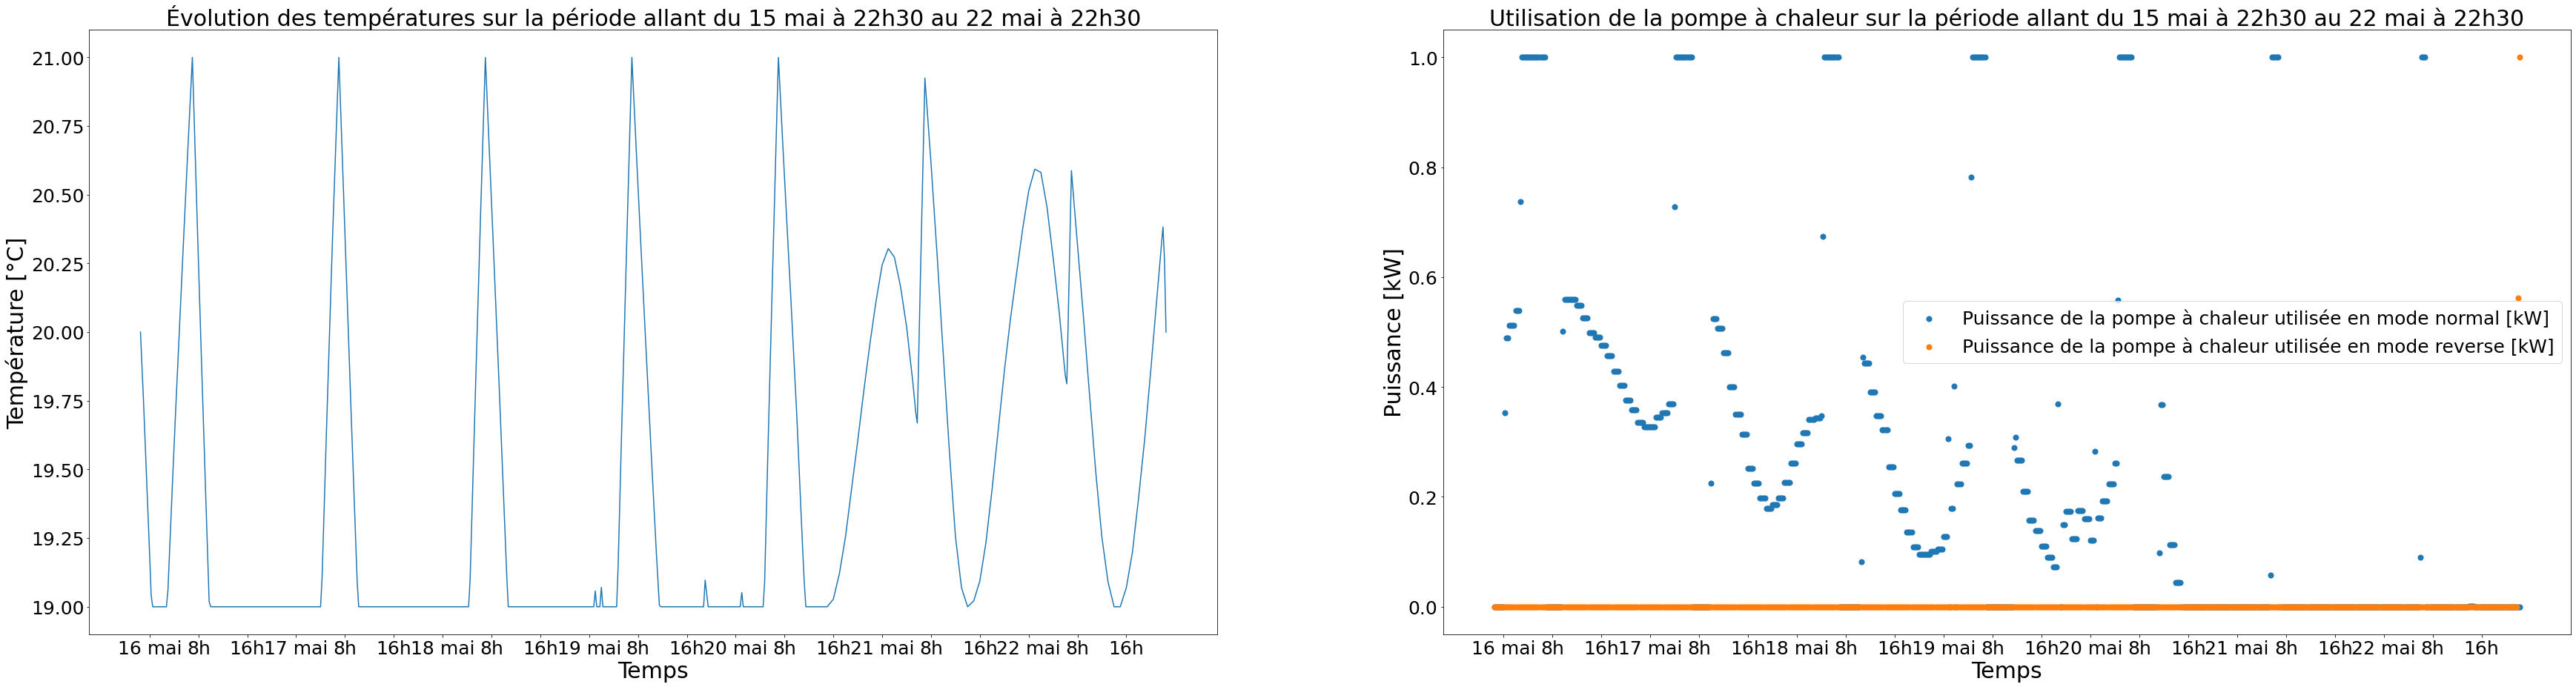

In [6]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : {Cout1:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

#### b) Intervalle de temps allant du 26 juin à 2h au 3 juillet à 2h

In [7]:
start = 17000
length = 7
t0 = time.time()
(result2, Cout2,T2,x2,y2) = min_cout(start, length)
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 1.859$. L'exécution a duré 64.928ms.


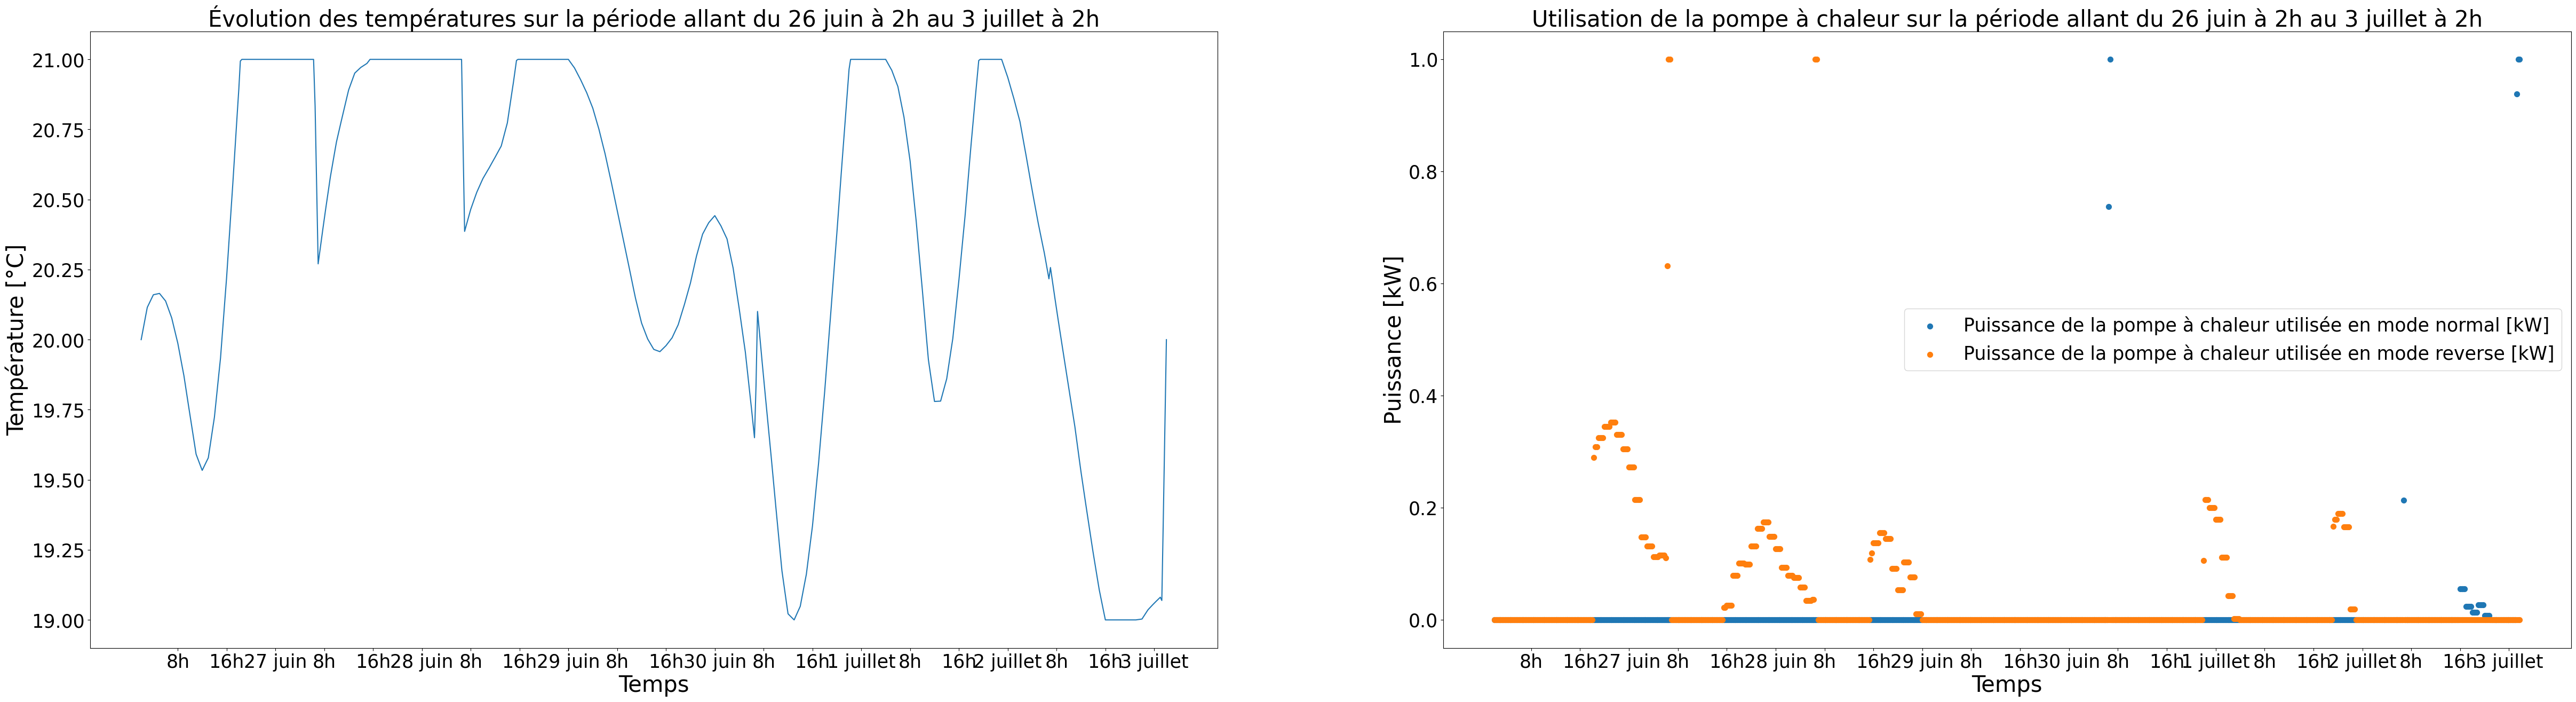

In [8]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Cout2:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

#### c) Commentaires

Pour les deux périodes, la majorité des contraintes serrées est le non-usage de la pompe. De plus, pour une température extérieure froide (resp. chaude), nous observons plus de contraintes serrées en $T_{min}$ (resp. $T_{max}$). En outre, il y a une corrélation entre pics d'utilisation de la pompe en mode normal (resp. reverse) et hausse (resp. baisse) de la température. D'autre part, nous constatons que pour les deux périodes, les pics d'utilisation ont lieu durant la nuit, à savoir quand l'électricité est moins chère. Enfin, lorsque la température extérieure est basse (resp. élevée), la pompe à chaleur est plus utilisée en mode normal (resp. reverse) et la température à l'intérieur est souvent dans la zone inférieure (resp. supérieure) des températures admissibles.

<div class="alert alert-block alert-info"><b>Question 1.3</b> :<br> 
    A partir de certaines informations fournies par le solver (et donc sans effectuer de nouveau calcul), prédisez l'effet sur le coût optimal d'une diminution de la tempéature minimale admissible. Faites de même pour une augmentation de la température maximale admissible. Commentez cette prédiction (en particulier à quel point elle est valide pour n'importe quelle variation des températures).
</div>

La fonction objectif du problème dual peut s'écrire
$$\begin{align}
max T_s.a + T_s.b + \sum_{j=0}^n (T_{min}.c_j + T_{max}.d_j) + \sum_{i=0}^{n-1}((1-\eta)T_{e,i}.e_i + \Omega.f_i)
\end{align}$$
avec $a$, $b$, $c_j$, $d_j$, $e_i$ et $f_i$ les variables, $j = 0,...,n$ et $i = 0,...,n-1$.

En outre, dans le dual, $a$, $b$ et $e_i$ sont des variables libres, $c_j \geq 0$ et $d_j$, $f_i \leq 0$.

Par le théorème de la dualité forte, qui peut s'appliquer ici car nous résolvons un problème d'optimisation linéaire, si le primal a un coût optimal fini, alors le dual a également un coût optimal fini et ces deux coûts sont égaux (et inversément). Par conséquent, nous remarquons que si $T_{min}$ diminue, la solution du problème dual va diminuer (car $c_j \geq 0$) et donc celle du primal aussi. Si $T_{max}$ augmente, la solution du problème dual va aussi diminuer (car $d_j \leq 0$) et celle du primal va suivre. Nous concluons donc qu'un élargissement de la zone des températures admissibles fera diminuer le coût minimal.

Une modification $T_{min} \mapsto T_{min} - \Delta T_{min}$ entraine donc une diminution du coût optimal d'approximativement (car la base varie légèrement) $\Delta T_{min} \sum_{i = 0}^{n} c_{j}^{*}$, avec $c_j^*$ les solutions optimales des variables du dual relatives aux contraintes $T_j \geq T_{min}$. Grâce aux informations fournies par le solver, nous obtenons que la somme des $c_j^*$ vaut environ $1.4085$ pour la première période. Une diminution de $\Delta T_{min}$ mènera donc localement à une diminution de $1.4085\Delta T_{min} \$$/$^{\circ}C$.

Une modification $T_{max} \mapsto T_{max} + \Delta T_{max}$ entraine donc une diminution du coût optimal d'approximativement (car la base varie légèrement) $\Delta T_{max} \sum_{i = 0}^{n} d_{j}^{*}$, avec $d_j^*$ les solutions optimales des variables du dual relatives aux contraintes $T_j \leq T_{max}$. Grâce aux informations fournies par le solver, nous obtenons que la somme des $d_j^*$ vaut environ $0.0976$ por la première période. Une augmentation de $\Delta T_{max}$ mènera donc localement à une diminution de $0.0976\Delta T_{max} \$$/$^{\circ}C$.

De la même manière, restreindre encore plus la zone des températures admissibles fera croître le coût minimal.

Cette prédiction n'est pas valable pour toutes les variations de températures mais seulement lorsque la base ne varie pas beaucoup (et donc pour des bornes proches des bornes initiales). L'approximation est locale.

<div class="alert alert-block alert-info"><b>Question 1.4</b> :<br> 
   Démontrez que, dans une solution optimale, l'activation simultanée du chauffage et du mode reverse durant la même période de temps est impossible.
</div>

Il est impossible que la pompe à chaleur soit utilisée en mode chauffage et en mode reverse de manière simultanée dans une solution optimale. En effet, les deux utilisations ayant un coût positif, utiliser la pompe à chaleur pour chauffer la pièce et l'utiliser en même temps pour la refroidir est absurde. Il vaut mieux dans ce cas ne l'utiliser que dans le mode normal (ou reverse) avec une plus faible puissance pour atteindre directement la température désirée. Cela permettra d'utiliser la pompe à chaleur en mode normal (ou reverse) avec une plus petite puissance et ne pas l'utiliser en mode reverse (ou normal), ce qui diminue le coût des deux côtés. Le but étant de minimiser le coût, cette approche est plus intéressante que d'utiliser la pompe à chaleur dans les deux modes de manière simultanée.

<div class="alert alert-block alert-info"><b>Question 1.5</b> :<br> 
    Modifiez votre modèle de façon à tenir compte des nouvelles contraintes suivantes :<br>
    - si la pompe à chaleur est utilisée (dans un mode ou dans l'autre), elle l'est au moins à 25% de sa puissance maximale. Il n'est donc plus possible d'utiliser la pompe à chaleur à très faible puissance.
<br>
    - si on décide d'allumer (ou d'éteindre) la pompe à chaleur, elle reste allumée (ou éteinte) sur une période de x heures consécutives. Ces périodes sont fixes : par exemple, si x=4h, il s'agit de [0h-4h], [4h-8h], [8h-12h], [12h-16h], etc. pour chaque journée.<br>
    Le nouveau modèle sera toujours obligatoirement linéaire, mais pourra faire appel à des variables discrètes. 
    Donnez votre formulation, et commentez brièvement.
</div>

(a) Nous avons que soit $x_i \ge \frac{\Omega}{4}$, soit $x_i = 0$ et que soit $y_i \ge \frac{\Omega}{4}$, soit $y_i = 0$. Ceci peut se réécrire $-x_{i} \le -\frac{\Omega}{4}$ ou $x_i \leq 0$, et $-y_{i} \le -\frac{\Omega}{4}$ ou $y_i \le 0$ car $x_i$, $y_i \geq 0$.

Prenons la contrainte $-x_{i} \le -\frac{\Omega}{4}$ ou $x_i \leq 0$. Pour exprimer qu'exactement une de ces deux contraintes est satisfaite pour chaque $i$, nous introduisons les variables binaires $a_i$ telles que $-x_{i} + \frac{\Omega}{4} \le M_1(1-a_i)$, $x_i \leq M_1a_i$ et $a_i \in \{0,1\}$, avec $M_1$ une constante suffisament grande telle que $-x_{i} + \frac{\Omega}{4} \le M_1$ et $x_i \leq M_1$ soient satisfaites pour tout $x_i$, $i = 0,...,n-1$, appartenant au domaine. Sachant que $0 \leq x_i + y_i \leq \Omega$ et $x_i$, $y_i \geq 0$, nous constatons que $M_1 = \Omega$ convient aux deux conditions. Notons que cette méthode ne permet que de demander qu'au moins une des deux contraintes soit satisfaite mais les deux contraintes ne pouvant être satisfaites simultanément, nous avons bien qu'exactement une des deux contraintes sera satisfaite.

De la même manière, nous obtenons pour la contrainte $-y_{i} \le -\frac{\Omega}{4}$ ou $y_i \le 0$ que $-y_{i} + \frac{\Omega}{4} \le \Omega(1-b_i)$, $y_i \leq \Omega b_i$ et $b_i \in \{0,1\}$.

Cela peut s'interpréter comme $a_i = 1$ si la pompe à chaleur est allumée en mode normal (dans ce cas, $x_i \ge \frac{\Omega}{4}$) et $0$ sinon (dans ce cas, $x_i \leq 0$ et donc $x_i = 0$), et $b_i = 1$ si la pompe à chaleur est allumée en mode reverse (dans ce cas, $y_i \ge \frac{\Omega}{4}$) et $0$ sinon (dans ce cas, $y_i \leq 0$ et donc $y_i = 0$).

En conclusion, nous rajoutons au modèle les contraintes
$$\begin{align}
-x_{i} + \frac{\Omega}{4} &\le \Omega(1-a_i), i = 0,...,n-1\\
x_i &\leq \Omega a_i, i = 0,...,n-1\\
-y_{i} + \frac{\Omega}{4} &\le \Omega(1-b_i), i = 0,...,n-1\\
y_i &\leq \Omega b_i, i = 0,...,n-1\\
a_i, b_i &\in \{0,1\}, i = 0, ..., n-1
\end{align}$$

(b) Note : Nous considérons des intervalles semi-ouverts à droite. Cela signifie que la pompe à chaleur est allumée ou éteinte sur $[0h, 4h[, [4h, 8h[ ...$. En outre, si la période sur laquelle l'optimisation doit être réalisée commence par exemple un jour à 22h30, ces intervalles sont déplacés à $[22h30, 2h30[, [2h30, 6h30[ ...$.

Ces variables $a_i$ et $b_i$ vont également permettre de répondre à la deuxième partie de la question. Soit $X$, le nombre d'heures consécutives durant lesquelles la pompe doit rester allumée. On a
$$\begin{align}
&\sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} \geq \frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} = 0\\
&\sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} \geq \frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} = 0,
\end{align}$$
ce qui est équivalent à
$$\begin{align}
&-\sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} \leq -\frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} \leq 0\\
&-\sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} \leq -\frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} \leq 0
\end{align}$$
car les $a_{i+kmX}$ et les $b_{i+kmX}$ sont positifs, avec $k = 0,..., \frac{nm}{60X}-1$, chaque k désignant un intervalle de X heures.
Remarque : $\frac{60X}{m}$ représente le nombre d'intervalles de $m$ minutes dans $X$ heures.

Ces contraintes peut se réécrire via les contraintes alternatives
$$\begin{align}
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} &\le M'_1(1-c_k)\\
\sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} &\le M'_1c_k\\
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} &\le M'_2(1-d_k)\\
\sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} &\le M'_2d_k\\
c_k, d_k &\in \{0,1\}\\
\end{align}$$

Cela peut s'interpréter comme $c_i = 1$ si la pompe à chaleur est allumée en mode normal durant $X$h et $0$ sinon, et $d_i = 1$ si la pompe à chaleur est allumée en mode reverse durant $X$h et $0$ sinon.

Il reste à trouver les valeurs de $M'_1$ et de $M'_2$. Comme $0 \leq a_{i+k.\frac{60X}{m}}, b_{i+k.\frac{60X}{m}} \leq 1$, nous voyons que $M'_1 = M'_2 = \frac{60X}{m}$ convient.

En conclusion, nous rajoutons au modèle les contraintes
$$\begin{align}
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}(1-c_k), k = 0,..., \frac{nm}{60X}-1\\
\sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}c_k, k = 0,..., \frac{nm}{60X}-1\\
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}(1-d_k), k = 0,..., \frac{nm}{60X}-1\\
\sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}d_k, k = 0,..., \frac{nm}{60X}-1\\
c_k, d_k &\in \{0,1\}, k = 0,..., \frac{nm}{60X}-1\\
\end{align}$$

<div class="alert alert-block alert-info"><b>Question 1.6</b> :<br> 
    Résolvez ce nouveau modèle, affichez les résultats et commentez (en particulier le temps de calcul). Choissisez d'abord une valeur x=4h, puis x=2h.
</div>

In [9]:
def min_new_cout(start, length, X):
    """
    Cette fonction calcule les moments auxquels nous devons allumer une pompe à chaleur dans un bâtiment de 360m³ à Montréal pour que
    la température à l'intérieur reste dans une certaine plage admissible, tout en minimisant le coût de l'électricité.
    Nous considérons une période de `length` jours, commençant à l'instant `start`.
    
    Arguments
    ---------
    start  : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    X      : int qui indique la durée des intervalles sur lesquels la pompe à chaleur doit être allumée ou éteinte [h] ;
    
    Retourne
    --------
    prob.status : string parmi {optimal, infeasible, unbounded} qui indique si la solution du problème est optimale,
                  si le problème est infaisable ou si la solution est non bornée ;
    prob.value  : float qui indique le coût minimal dû à l'utilisation de la pompe à chaleur afin de rester dans la plage admissible
                  des températures [$]. Si le problème est impossible, prob.value = -inf. Si le problème est non borné,
                  prob.value = -inf ;
    T.value     : numpy array de float qui indique la température dans le bâtiment durant la période de `length` jours considérée,
                  par intervalles de m minutes [°C] ;
    x.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                  intervalles de temps de m minutes [kW] ;
    y.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                  intervalles de temps de m minutes [kW] ;
    """
    
    # Dans un premier temps, il faut trouver quels sont les coûts aux différents moments sur base de l'emplacement de l'instant de départ.
    cout = np.repeat(plein, temps)
    debut = start%(temps)
    moments = np.concatenate((np.arange(debut,temps), np.arange(0,debut)))
    cout[moments < start_plein*60/m] = creux
    cout[moments >= end_plein*60/m] = creux
    cout = np.tile(cout,length)

    # Ensuite, il faut trouver les températures extérieures à ces moments et le COP de la pompe à chaleur utilisée en mode normal correspondant.
    Te = Text[start : start+length*temps]
    COPnor = COPnormal(Te)
    
    # Initialisation des variables du problème
    T = cp.Variable(temps*length + 1)
    x = cp.Variable(temps*length, nonneg=True)
    y = cp.Variable(temps*length, nonneg=True)
    a = cp.Variable(temps*length, boolean = True)
    b = cp.Variable(temps*length, boolean = True)
    c = cp.Variable(int(temps*length*m/(60*X)), boolean = True)
    d = cp.Variable(int(temps*length*m/(60*X)), boolean = True)
    
    # Modélisation du problème
    objective = cp.Minimize(cp.sum(cp.multiply(cout,(x+y)))*m/60)
    constraints = [T[0] == Tinit,
                   T[-1] == Tinit,
                   T >= Tinf,
                   T <= Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= puiMax,
                   -x+puiMax/4 <= puiMax*(1-a), x <= puiMax*a,
                   -y+puiMax/4 <= puiMax*(1-b), y <= puiMax*b
                  ]
    for k in range (int(temps*length*m/(60*X))) :
        constraints.append(60*X/m - cp.sum(a[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*(1-c[k])/m)
        constraints.append(cp.sum(a[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*c[k]/m)
        constraints.append(60*X/m - cp.sum(b[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*(1-d[k])/m)
        constraints.append(cp.sum(b[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*d[k]/m)

    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    
    return (prob.status, prob.value, T.value, x.value, y.value)

#### a) Intervalle de temps allant du 15 mai à 22h30 au 22 mai à 22h30

In [10]:
start = 13050
length = 7
t0 = time.time()
(result1, Cout1,T1,x1,y1) = min_new_cout(start, length, 4) # intervalles de 4h obligatoires
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : 8.904$. L'exécution a duré 9279.960ms.


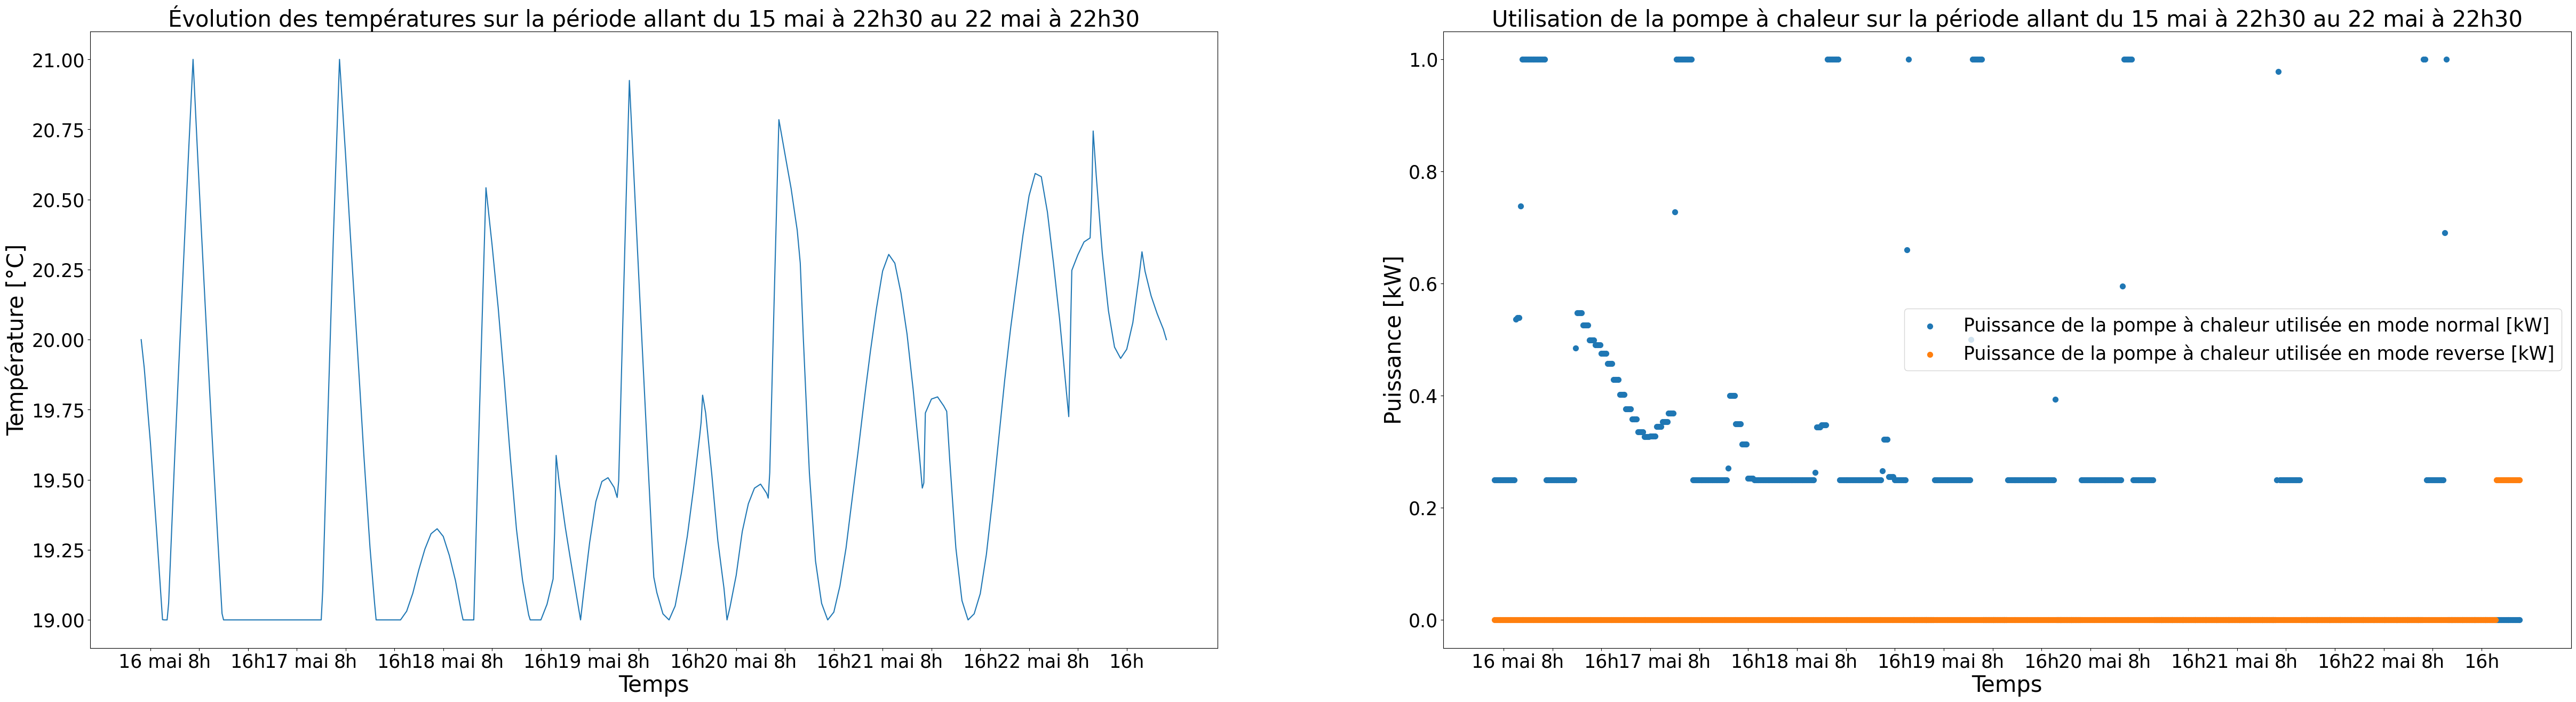

In [11]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : {Cout1:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

In [12]:
start = 13050
length = 7
t0 = time.time()
(result1, Cout1,T1,x1,y1) = min_new_cout(start, length, 2) # intervalles de 2h obligatoires
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : 8.424$. L'exécution a duré 12392.827ms.


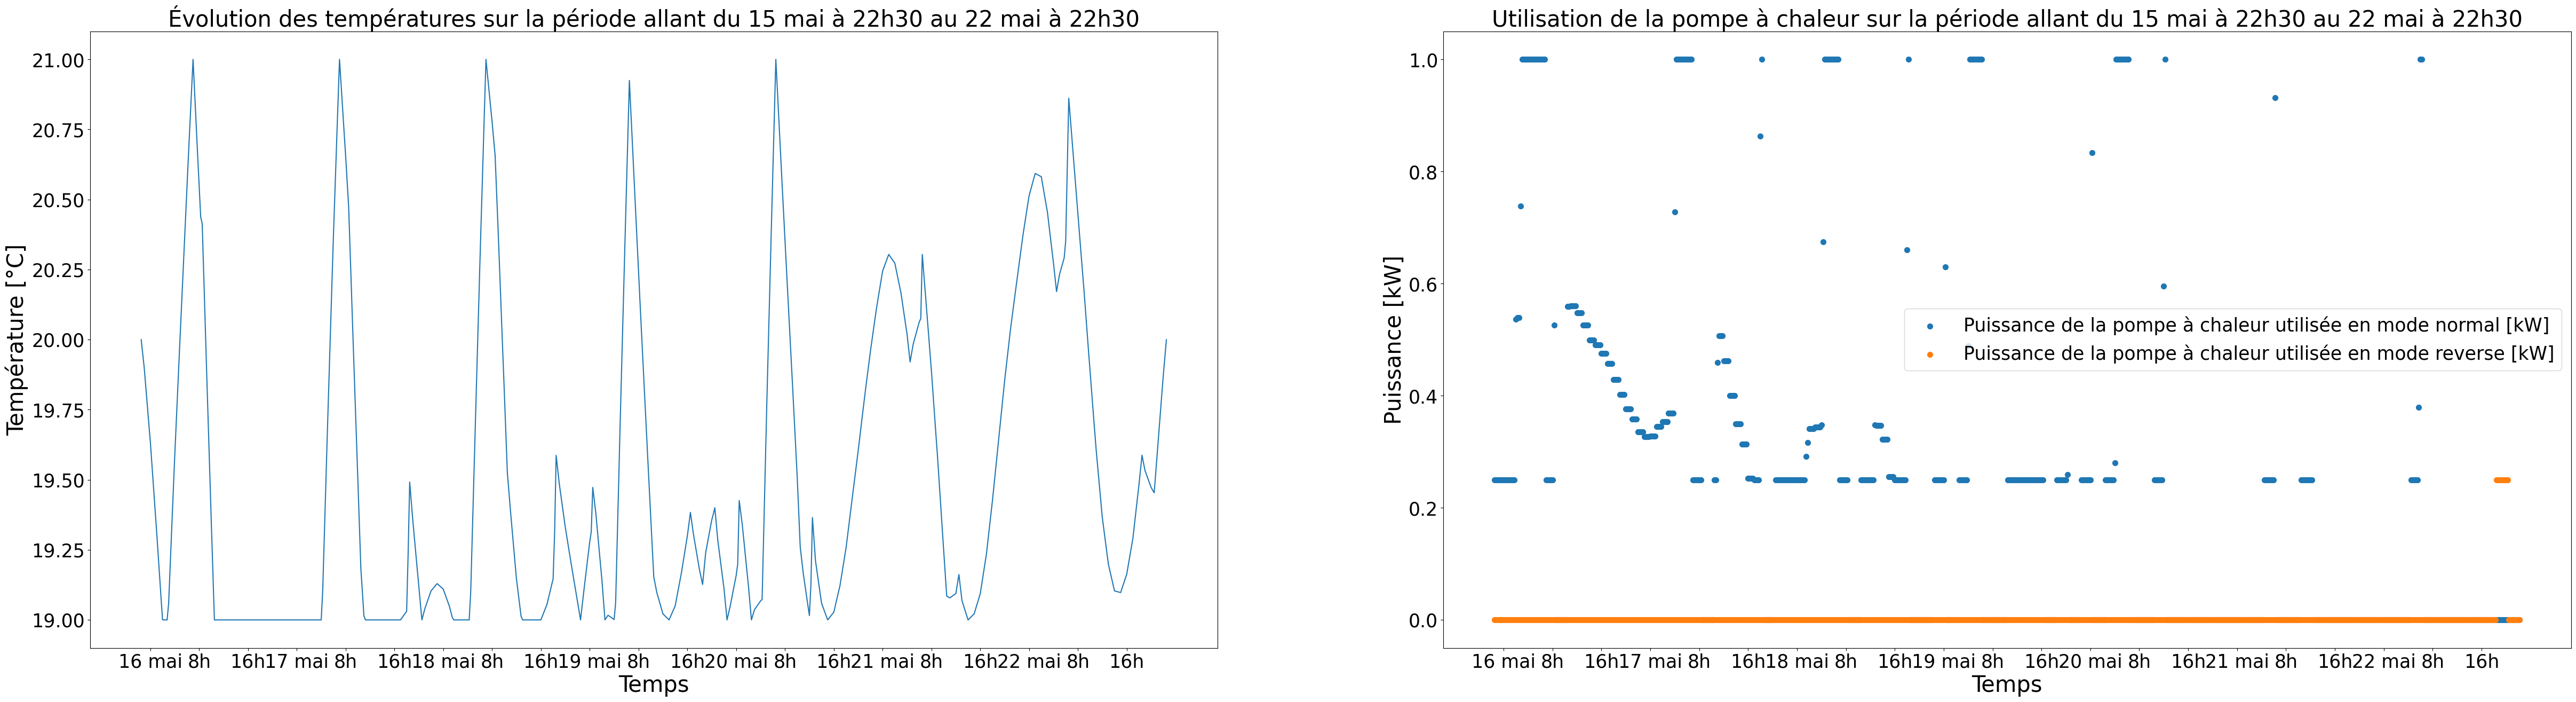

In [13]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 16 mai à 22h30 au 23 mai à 22h30 : {Cout1:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

#### b) Intervalle de temps allant du 26 juin à 2h au 3 juillet à 2h

In [14]:
start = 17000
length = 7
t0 = time.time()
(result2, Cout2,T2,x2,y2) = min_new_cout(start, length, 4) # intervalles de 4h obligatoires
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 2.626$. L'exécution a duré 19146.827ms.


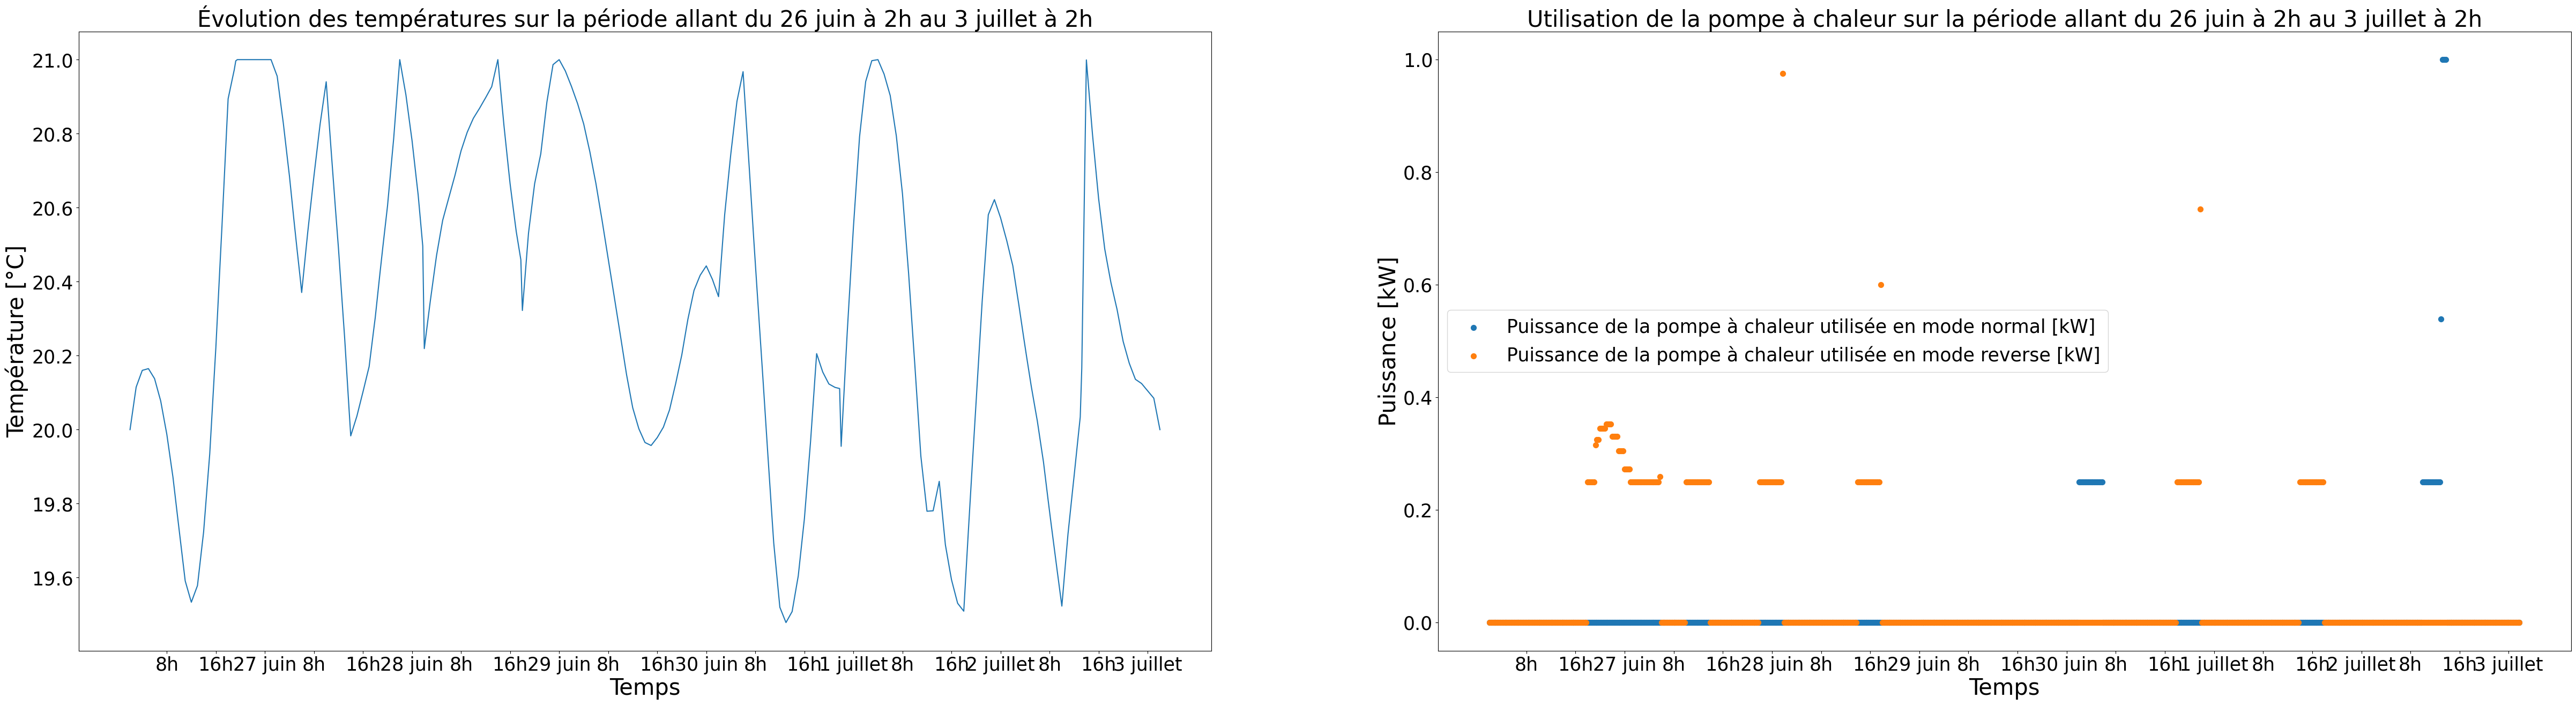

In [15]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Cout2:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

In [16]:
start = 17000
length = 7
t0 = time.time()
(result2, Cout2,T2,x2,y2) = min_new_cout(start, length, 2) # intervalles de 2h obligatoires
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 1.969$. L'exécution a duré 8769.665ms.


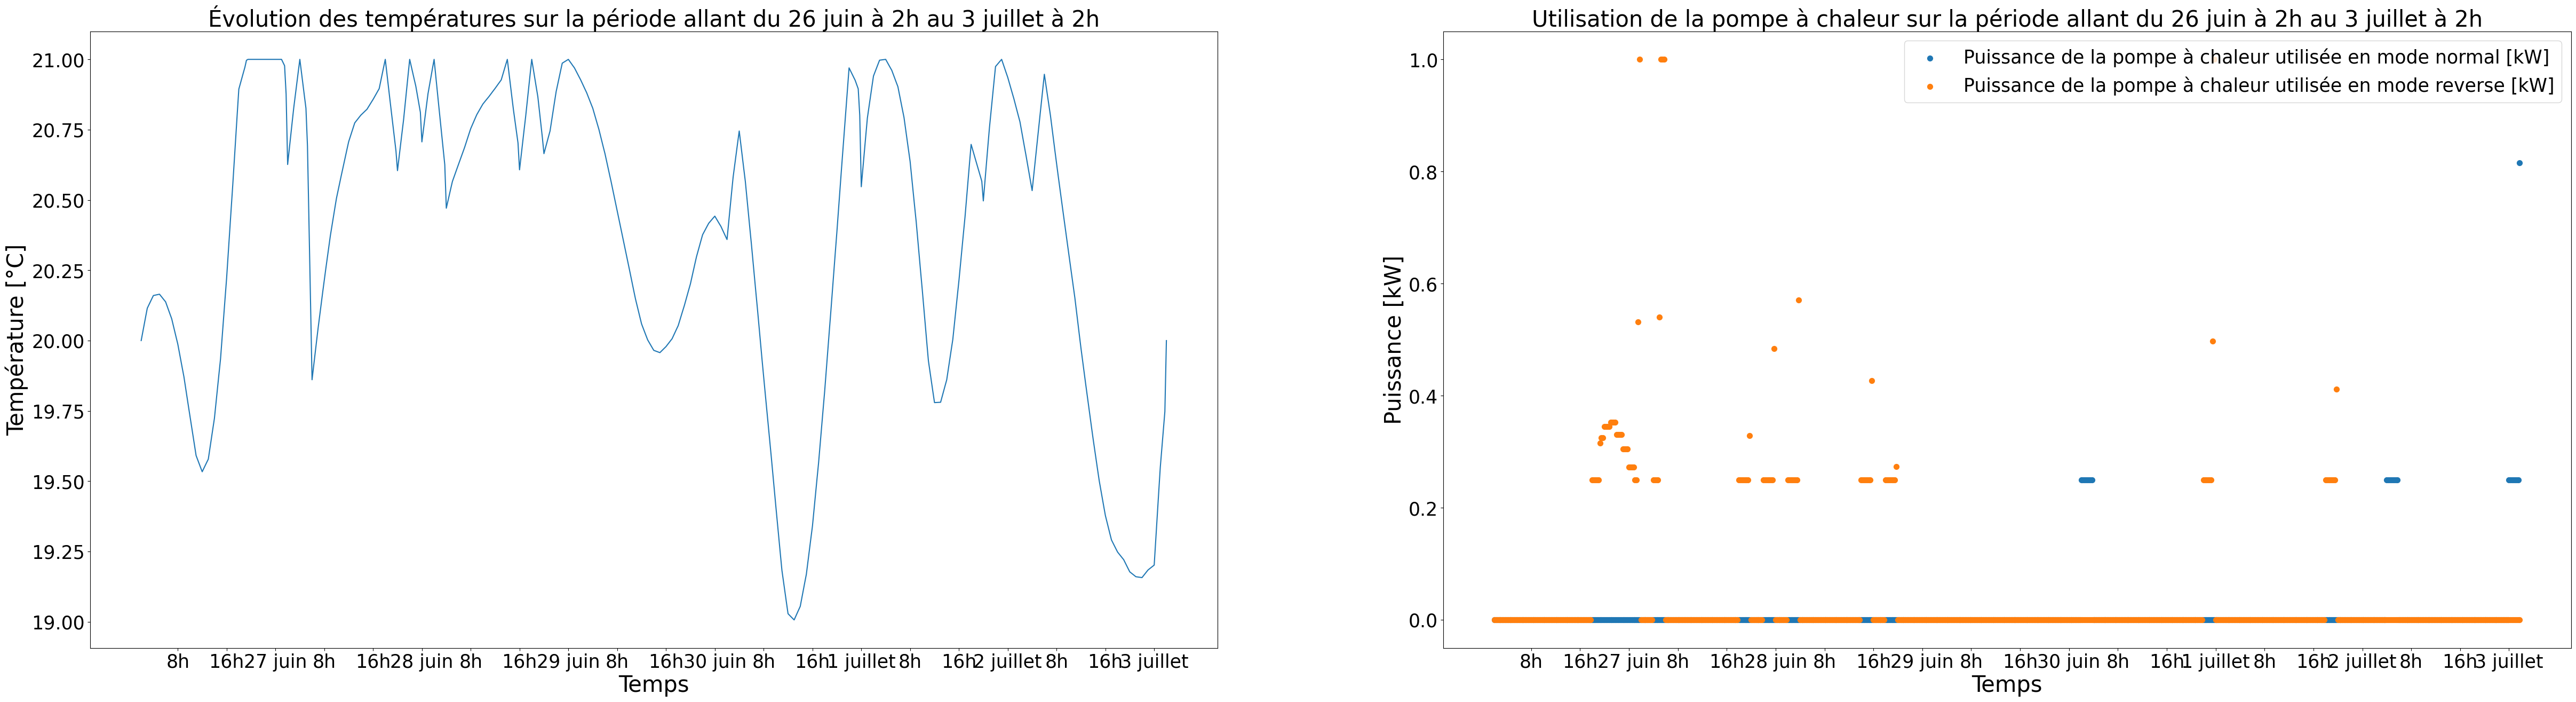

In [17]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Cout2:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

In [18]:
start = 17000
length = 7
t0 = time.time()
# intervalles de 8h obligatoires pour observer que la pompe à chaleur peut être utilisée dans les deux modes en même temps.
(result2, Cout2,T2,x2,y2) = min_new_cout(start, length, 8)
t1 = time.time()

Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 5.113$. L'exécution a duré 10891.601ms.


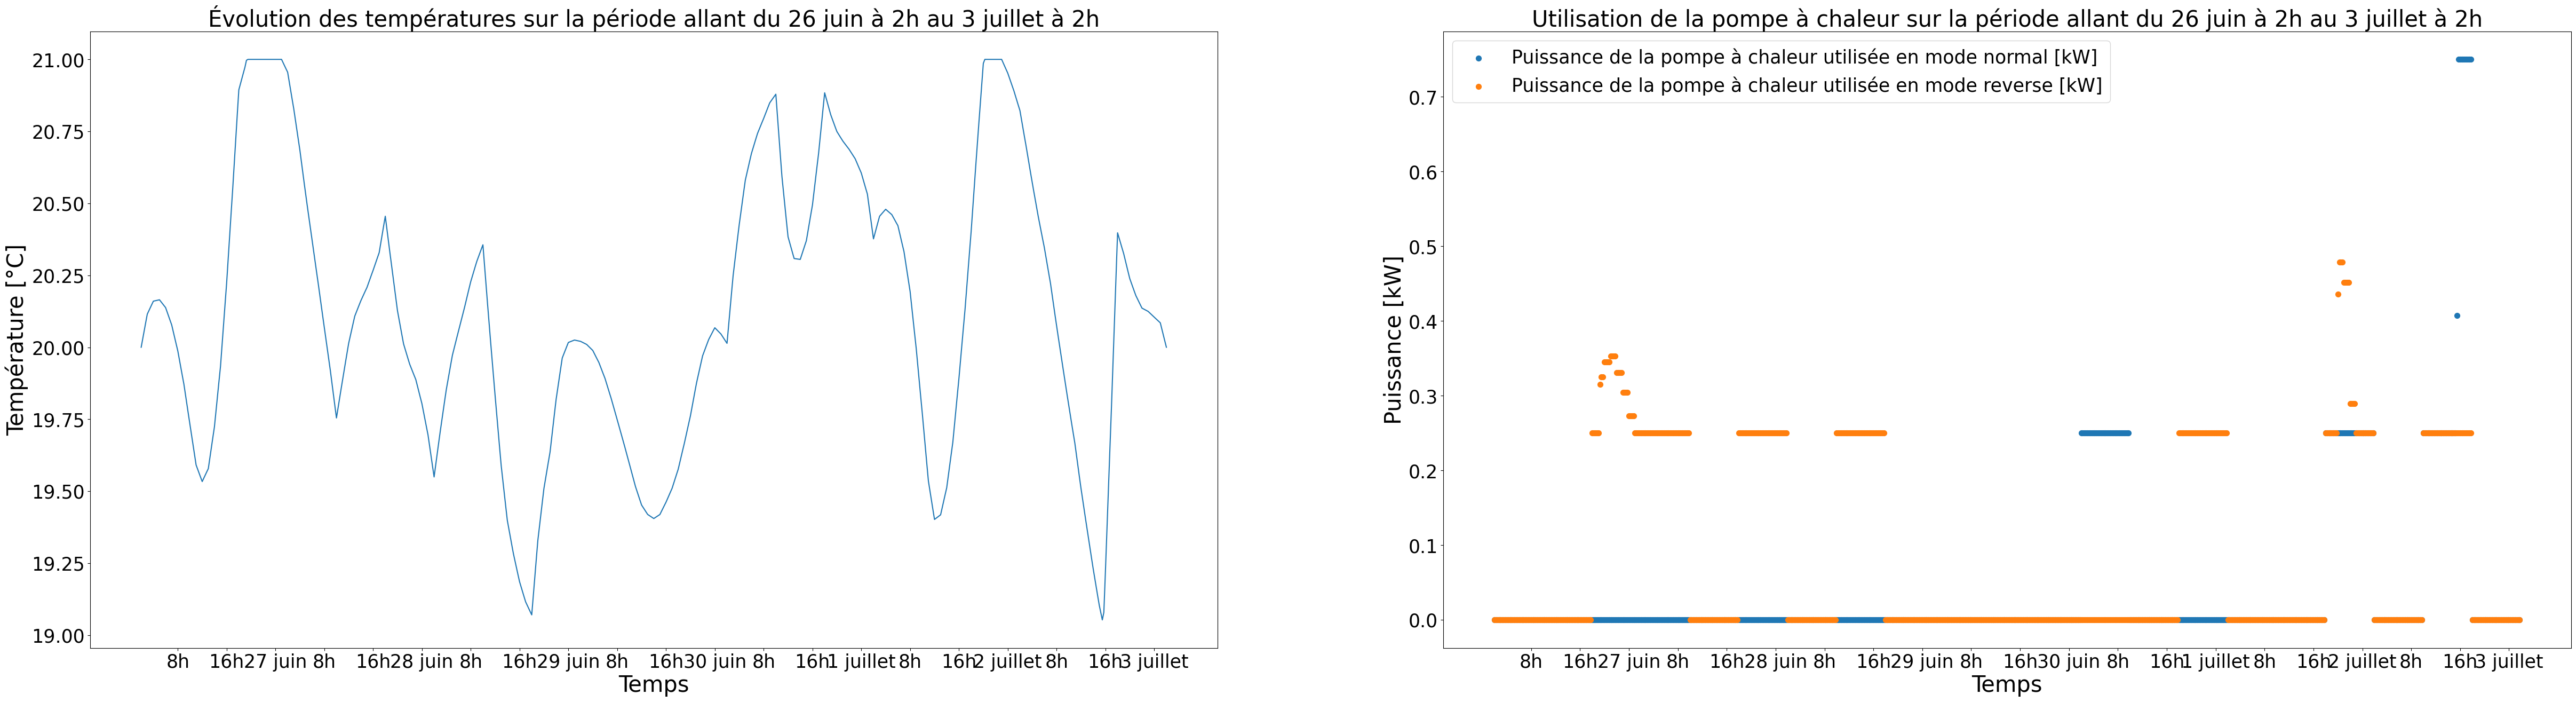

In [19]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Coût minimal pour l'utilisation de la pompe à chaleur lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Cout2:.3f}$. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

#### c) Commentaires

Nous constatons que le temps d'exécution de ce nouveau problème est beaucoup plus élevé. Ceci est du à l'augmentation du nombre de contraintes. Pour la première période, le temps d'exécution est plus long lorsque $X = 2h$ que lorsque $X = 4h$, alors que c'est l'inverse pour la seconde période. Cela dépend du nombre d'itérations de l'algorithme de résolution et de la chance de trouver rapidement le sommet optimal ou non.

En outre, nous constatons que plus les périodes sur lesquelles la pompe doit être allumée ou éteinte sont longues, plus le coût minimal augmente et plus il y a de périodes d'utilisation non nulles. Toutefois, la forme générale des graphes de température reste la même.

Enfin, comme expliqué à la question 1.7, nous constatons qu'il est possible d'avoir la pompe à chaleur utilisée dans les deux modes en même temps.

<div class="alert alert-block alert-info"><b>Question 1.7</b> :<br> 
    Décrivez comment on pourrait apporter les modifications suivantes au modèle (mais sans les implémenter): <br>
    -(a) tenir compte d'un coût fixe à payer pour chaque intervalle de temps où la pompe à chaleur est utilisée<br>
    -(b) minimiser le nombre d'allumages de la pompe à chaleur (un allumage = passage de l'état 'éteint' lors d'un invervalle de temps à l'état 'allumé' lors de l'intervalle de temps suivant)<br>
    -(c) dans ce nouveau modèle il n'est plus nécessairement impossible d'observer dans une solution optimale l'activation simultanée du chauffage et du mode reverse au cours du même intervalle de temps : expliquez pourquoi, et proposez une contrainte permettant d'éliminer cette possibilité
</div>

(a) En reprenant les variables $c_i$ et $d_i$ définies à la question 1.5, il faut ajouter à la somme de la fonction objectif le terme $f\max \{c_i, d_i\}$, avec $f$ le coût fixe. En effet, le coût fixe sera payé une fois si la pompe est allumée dans minimum un des deux modes et ne sera pas payé si les deux modes sont éteints. Soit les variables $t_k$ telles que $t_k \geq c_k$ et $t_k \geq d_k$, $k = 0,..., \frac{nm}{60X}-1$.

La nouvelle fonction objectif devient donc
$$\begin{align}
\text{min } &\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i) + \sum_{k=0}^{\frac{nm}{60X}-1}f.t_k
\end{align}$$
et il faut ajouter les contraintes $t_k \geq c_k$ et $t_k \geq d_k$, $k = 0,..., \frac{nm}{60X}-1$.

(b)
Un allumage se traduit par :
$$\begin{align}
t_{k-1} = 0\\
t_{k} = 1\\
\end{align}$$
avec comme condition initiale que $t_{-1} = 0$.

On peut modéliser une variable binaire $\lambda_{k}$ qui vaut 1 lors d'un allumage et 0 sinon via les contraintes suivantes:
$$\begin{align}
\lambda_{k} \in \{0,1\}\\
\lambda_{k} + t_{k-1} \le 1\\
t_{k} - t_{k-1} \le \lambda_{k} \le t_{k}
\end{align}$$
On peut dès lors prendre la fonction objectif
$$\begin{align}
\text{min } \sum_{k = 0}^{\frac{nm}{60X}-1} \lambda_{k}
\end{align}$$

(c) La pompe devant absolument être allumée à $25\%$ de sa puissance durant un intervalle de plusieurs heures, il est parfois absolument nécessaire de l'utiliser dans un mode pour rester dans la zone admissible. Cependant, l'utiliser durant plusieurs heures peut mener à dépasser l'autre borne des températures. Il faut donc utiliser les deux modes dans des proportions différentes pour rester dans la zone admissible durant l'intervalle.

Pour éviter cet incident, nous pouvons imposer la contrainte que $x_i = 0 \lor y_i = 0$, $i = 0,...,n-1$, qui peut se réécrire $x_i \leq 0 \lor y_i \leq 0$ car $x_i, y_i \geq 0$. Soient les variables binaires $\psi_i$, $i = 0,...,n-1$. Cette contrainte peut être modélisée à l'aide des contraintes alternatives

$$\begin{align}
x_{i} &\le M(1-\psi_{i}), i = 0,...,n-1\\
y_{i} &\le M\psi_{i}, i = 0,...,n-1\\
\psi_i &\in \{0,1\}, i = 0,...,n-1
\end{align}$$

Pour trouver $M$, nous constatons que $M = \Omega$ convient, par la contrainte $x_i + y_i \leq \Omega$.

**Tâche 2** : on souhaite réduire le coût d'utilisation de la pompe à chaleur, et on va fixer le budget maximal à une certaine proportion du coût minimal identifié lors de la première tâche. Pour diminuer les coûts, on va permettre aux températures de sortir de la plage admissible définie plus haut (on abandonne aussi la contrainte sur la température finale, qui devient libre). On va cependant alors comptabiliser la quantité d'_inconfort_ éventuellement subi durant chaque intervalle de temps, qui sera proportionnel au dépassement de la température maximale admissible, ou au dépassement par le bas de la température minimale admissible. On cherche alors à **minimiser l'inconfort total** (somme des inconforts sur toute la période considérée) **tout en respectant la contrainte de budget**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.


<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- inconfort minimal + même graphiques que pour tâche 1 + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées lors de la tâche 1
</div>

---

<div class="alert alert-block alert-info"><b>Question 2.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation)  
</div>

Soient les variables :
 - $T_j, j = 0,...,n$, la température dans le bâtiment à l'instant j [°C]. Les $T_j$ sont espacés de manière régulière de $m$ minutes ;
 - $x_i, i = 0,...,n-1$, la puissance de la pompe à chaleur, utilisée en mode normal, durant l'intervalle $[T_i, T_{i+1}]$ [kW] ;
 - $y_i, i = 0,...,n-1$, la puissance de la pompe à chaleur, utilisée en mode reverse, durant l'intervalle $[T_i, T_{i+1}]$ [kW] ;
 - $\delta_j, j = 0,...,n$, la différence de température avec la borne inférieure de la plage admissible, si la température est inférieure à cette borne inférieure [°C] ;
 - $\epsilon_j, j = 0,...,n$, la différence de température avec la borne supérieure de la plage admissible, si la température est supérieure à cette borne supérieure [°C].
 
Le problème revient à
$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\delta_j + d_1.\epsilon_j \\
&T_0 = T_s\\
&\delta_j = 0 \vee \epsilon_j = 0, \text{  } j = 0,...,n\\
&\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i) \leq C\\
&\delta_j = T_{inf} - T_j \text{  si  } T_j < T_{inf}, 0 \text{ sinon}, j = 0,...,n\\
&\epsilon_j = T_j - T_{sup} \text{  si  } T_j > T_{sup}, 0 \text{ sinon}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,671\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

avec
 - $d_0$, l'inconfort par degré °C en dessous de la température minimale par quart d'heure [-] ;
 - $d_1$, l'inconfort par degré °C au-dessus de la température maximale par quart d'heure [-] ;
 - $T_s$, la température dans le bâtiment au début de la période [°C] ;
 - $c_i, i = 0,...,n-1$, le coût de l'électricité durant l'intervalle $[T_i, T_{i+1}]$ (dépend de si on est en heure creuse ou pleine) [\$/kWh] ;
 - $C$, le coût maximal qu'on est prêt à payer pour l'utilisation de la pompe à chaleur sur la période de $m$ jours [\$] ;
 - $T_{inf}, T_{sup}$, les bornes sur la température admissible [°C] ;
 - $\eta$, un coefficient de proportionnalité [-] ;
 - $\alpha_i = 3 + 10.abs\left(tanh\left(\frac{T_{e,i}}{100}\right)\right).tanh\left(\frac{T_{e,i}}{100}\right)$, le coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode normal durant l'intervalle $[T_i, T_{i+1}]$ [-] ;
 - $\beta$, le coefficient de performance de la pompe à chaleur lorsqu'elle est utilisée en mode reverse [-] ;
 - $\gamma$, le nombre de $kWh$ nécessaires pour chauffer la pièce de $\theta^{\circ} C$ [kWh] ;
 - $\Omega$, la puissance électrique maximale que peut consommer la pompe à chaleur [kW].
 
Remarques :
 - Si $c_i$ représente le prix à payer par kWh, alors $\frac{c_i.m}{60}$ représente le prix à payer par kW pour une utilisation de $m$ minutes ;
 - On a besoin de $\gamma \text{  } kW$ durant une heure pour faire chauffer (resp. refroidir) le bâtiment de $\theta^{\circ} C$. Dès lors, on a besoin de $\frac{60}{m.\theta}.\gamma \text{  } kW$ durant $m$ minutes pour faire chauffer (resp. refroidir) la pièce de $1^{\circ} C$ en $m$ minutes. Ainsi, si $x_i$ (resp. $y_i$) représente la puissance de la pompe à chaleur, utilisée en mode normal (resp. reverse), durant l'intervalle $[T_i, T_{i+1}]$, la température dans la pièce augmentera (resp. diminuera) de $\frac{m.\theta.\alpha_i.x_i}{60.\gamma}$ (resp. $\frac{m.\theta.\beta.y_i}{60.\gamma}$) durant cet intervalle.

Il reste trois contraintes qui ne sont pas linéaires :
 - $\delta_j = 0 \vee \epsilon_j = 0, \text{  } j = 0,...,n$. Cependant, nous pouvons "supprimer" cette contrainte par définition de $\delta_j$ et $\epsilon_j$. En effet, ces deux variables étant directement liées à $T_j$, il n'est pas possible que les deux soient non nulles parce que $T_j$ a une valeur unique et on ne peut donc pas se retrouver en dessous de la température minimale et au-dessus de la température maximale en même temps ;
 - $\delta_j = T_{inf} - T_j \text{  si  } T_j < T_{inf}, 0 \text{ sinon}, j = 0,...,n$. Cette contrainte peut être représentée comme $\delta_j = max(0,T_{inf} - T_j)$ ce qui est équivalent aux deux contraintes $\delta_j \geq 0$ et $\delta_j \geq T_{inf} - T_j$. Comme on souhaite minimiser $\delta_j$, il y aura toujours au minimum une de ces deux contraintes qui sera serée parce qu'on n'a jamais intérêt à avoir un plus grand écart que le minimal possible ;
 - $\epsilon_j = T_j - T_{sup} \text{  si  } T_j > T_{sup}, 0 \text{ sinon}, j = 0,...,n$. Cette contrainte peut être représentée comme $\epsilon_j = max(0,T_j - T_{sup})$ ce qui est équivalent aux deux contraintes $\epsilon_j \geq 0$ et $\epsilon_j \geq T_j - T_{sup}$. Comme on souhaite minimiser $\epsilon_j$, il y aura toujours au minimum une de ces deux contraintes qui sera serée parce qu'on n'a jamais intérêt à avoir un plus grand écart que le minimal possible.
 
Finalement, le problème revient à
$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\delta_j + d_1.\epsilon_j \\
&T_0 = T_s\\
&\sum_{i=0}^{n-1} \frac{c_i}{4}.(x_i+y_i) \leq C\\
&\delta_j \geq T_{inf} - T_j, j = 0,...,n\\
&\epsilon_j \geq T_j - T_{sup}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

<div class="alert alert-block alert-info"><b>Question 2.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.modélisation/reformulation)  
</div>

In [20]:
def min_inconfort (start, length, C) :
    """
    Cette fonction calcule les moments auxquels nous devons allumer une pompe à chaleur dans un bâtiment de 360m³ à Montréal
    pour minimiser l'inconfort total, avec une contrainte de budget.
    L'inconfort à un instant j est défini comme (less*max(0,T_inf-T_j) + greater*max(0,T_j-T_sup)).
    Nous considérons une période de `length` jours, commençant à l'instant `start`.
    
    Arguments
    ---------
    start         : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length        : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    C             : float qui indique le coût maximal qu'on est prêt à payer pour l'utilisation de la pompe à chaleur sur une période de `length` jours [$] ;
    
    Retourne
    --------
    prob.status : string parmi {optimal, infeasible, unbounded} qui indique si la solution du problème est optimale,
                  si le problème est infaisable ou si la solution est non bornée ;
    prob.value  : float qui indique l'inconfort minimal [-]. Si le problème est impossible, prob.value = -inf.
                  Si le problème est non borné, prob.value = -inf ;
    T.value     : numpy array de float qui indique la température dans le bâtiment durant la période de sept jours considérée,
                  par intervalles de 15 minutes [°C] ;
    x.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    y.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    """    
    # Dans un premier temps, il faut trouver quels sont les coûts aux différents moments sur base de l'emplacement de l'instant de départ.
    c = np.repeat(plein, temps)
    debut = start%temps
    moments = np.concatenate((np.arange(debut,temps), np.arange(0,debut)))
    c[moments < start_plein*60/m] = creux
    c[moments >= end_plein*60/m] = creux
    c = np.tile(c,length)
    
    # Ensuite, il faut trouver les températures extérieures à ces moments et le COP de la pompe à chaleur utilisée en mode normal correspondant.
    Te = Text[start : start+length*temps]
    COPnor = COPnormal(Te)
    
    # Initialisation des variables du problème
    T = cp.Variable(temps*length + 1)
    x = cp.Variable(temps*length, nonneg=True)
    y = cp.Variable(temps*length, nonneg=True)
    ΔinfT = cp.Variable(temps*length+1, nonneg=True)
    ΔsupT = cp.Variable(temps*length+1, nonneg=True)
    
    # Modélisation du problème
    objective = cp.Minimize(cp.sum(less*ΔinfT + greater*ΔsupT))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c,(x+y))*m/60) <= C,
                   ΔinfT >= Tinf - T,
                   ΔsupT >= T - Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= puiMax]

    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start = True)
    
    # Pour la question 3.2
    # print (constraints[1].dual_value)
    
    return (prob.status, prob.value, T.value, x.value, y.value)

#### a) Intervalle de temps allant du 15 mai à 22h30 au 22 mai à 22h30

In [21]:
start = 13050
length = 7
Cout1 = min_cout(start, length)[1]
t0 = time.time()
(result1, Inconfort1,T1,x1,y1) = min_inconfort(start, length, Cout1/2)
t1 = time.time()

Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : 4492.241. L'exécution a duré 220.088ms.


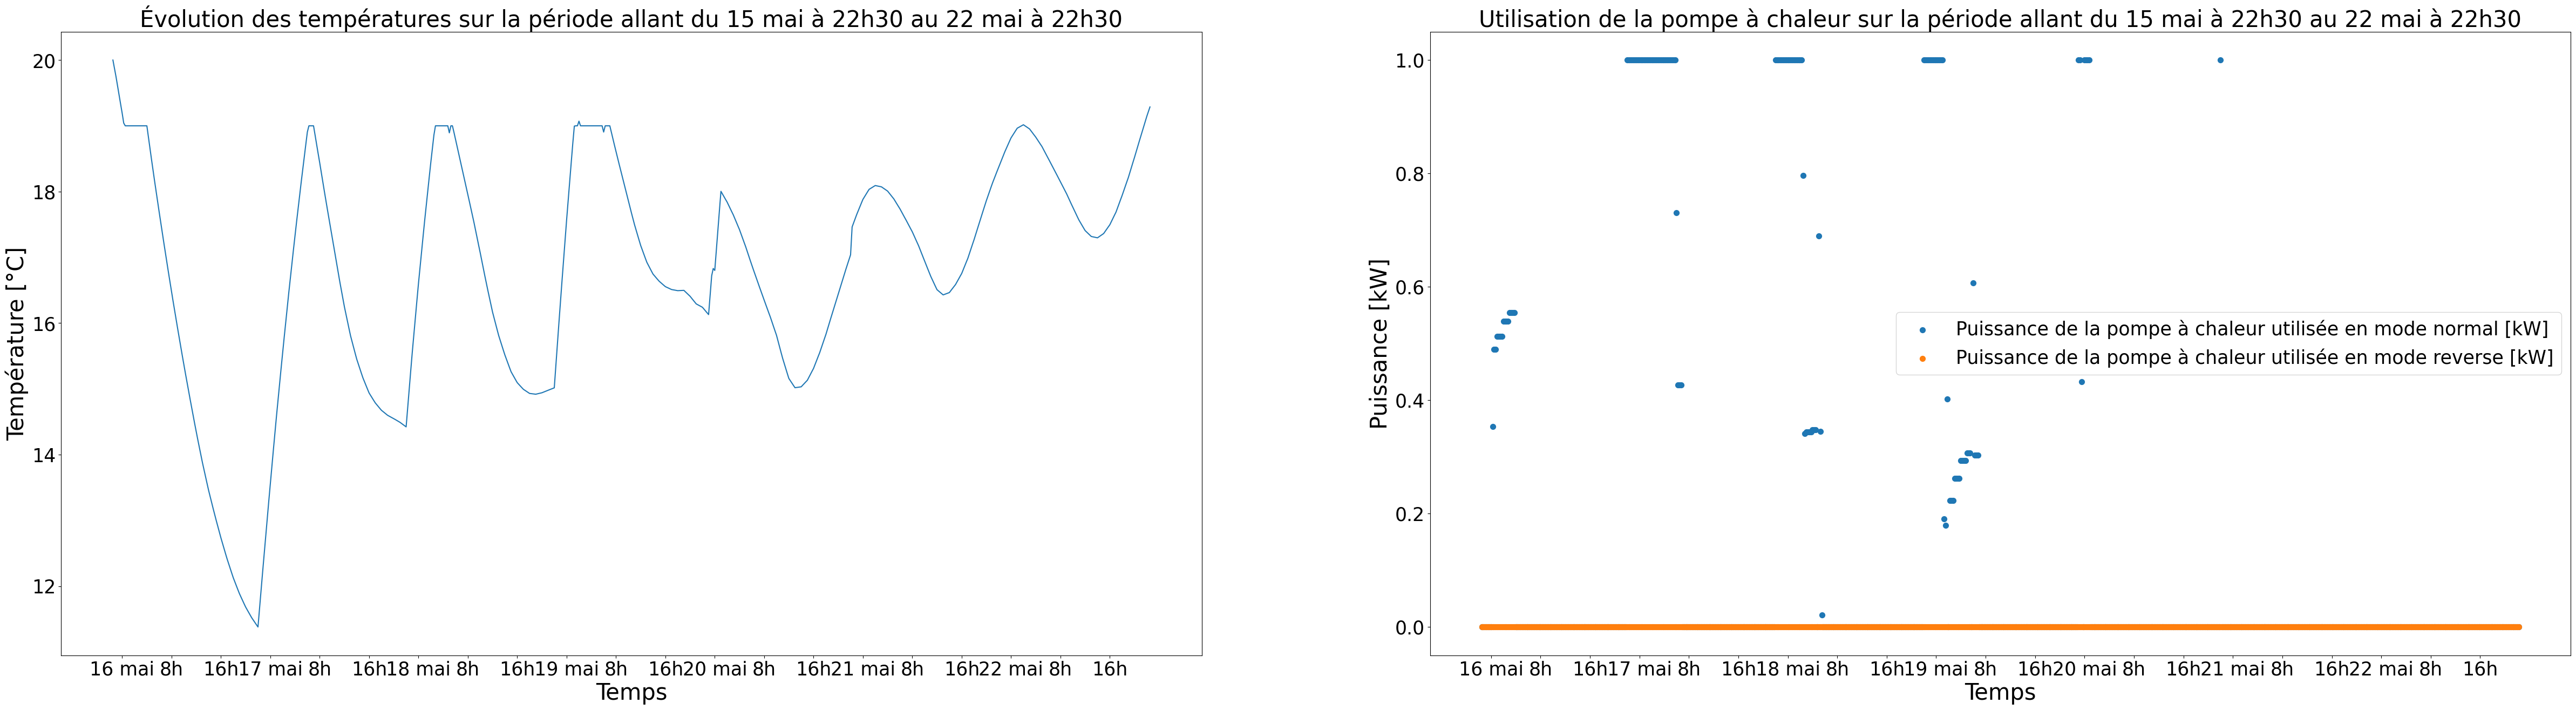

In [22]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : {Inconfort1:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

#### b) Intervalle de temps allant du 26 juin à 2h au 3 juillet à 2h

In [23]:
start = 17000
length = 7
Cout2 = min_cout(start, length)[1]
t0 = time.time()
(result2, Inconfort2,T2,x2,y2) = min_inconfort(start, length, Cout2/2)
t1 = time.time()

Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 116.672. L'exécution a duré 187.871ms.


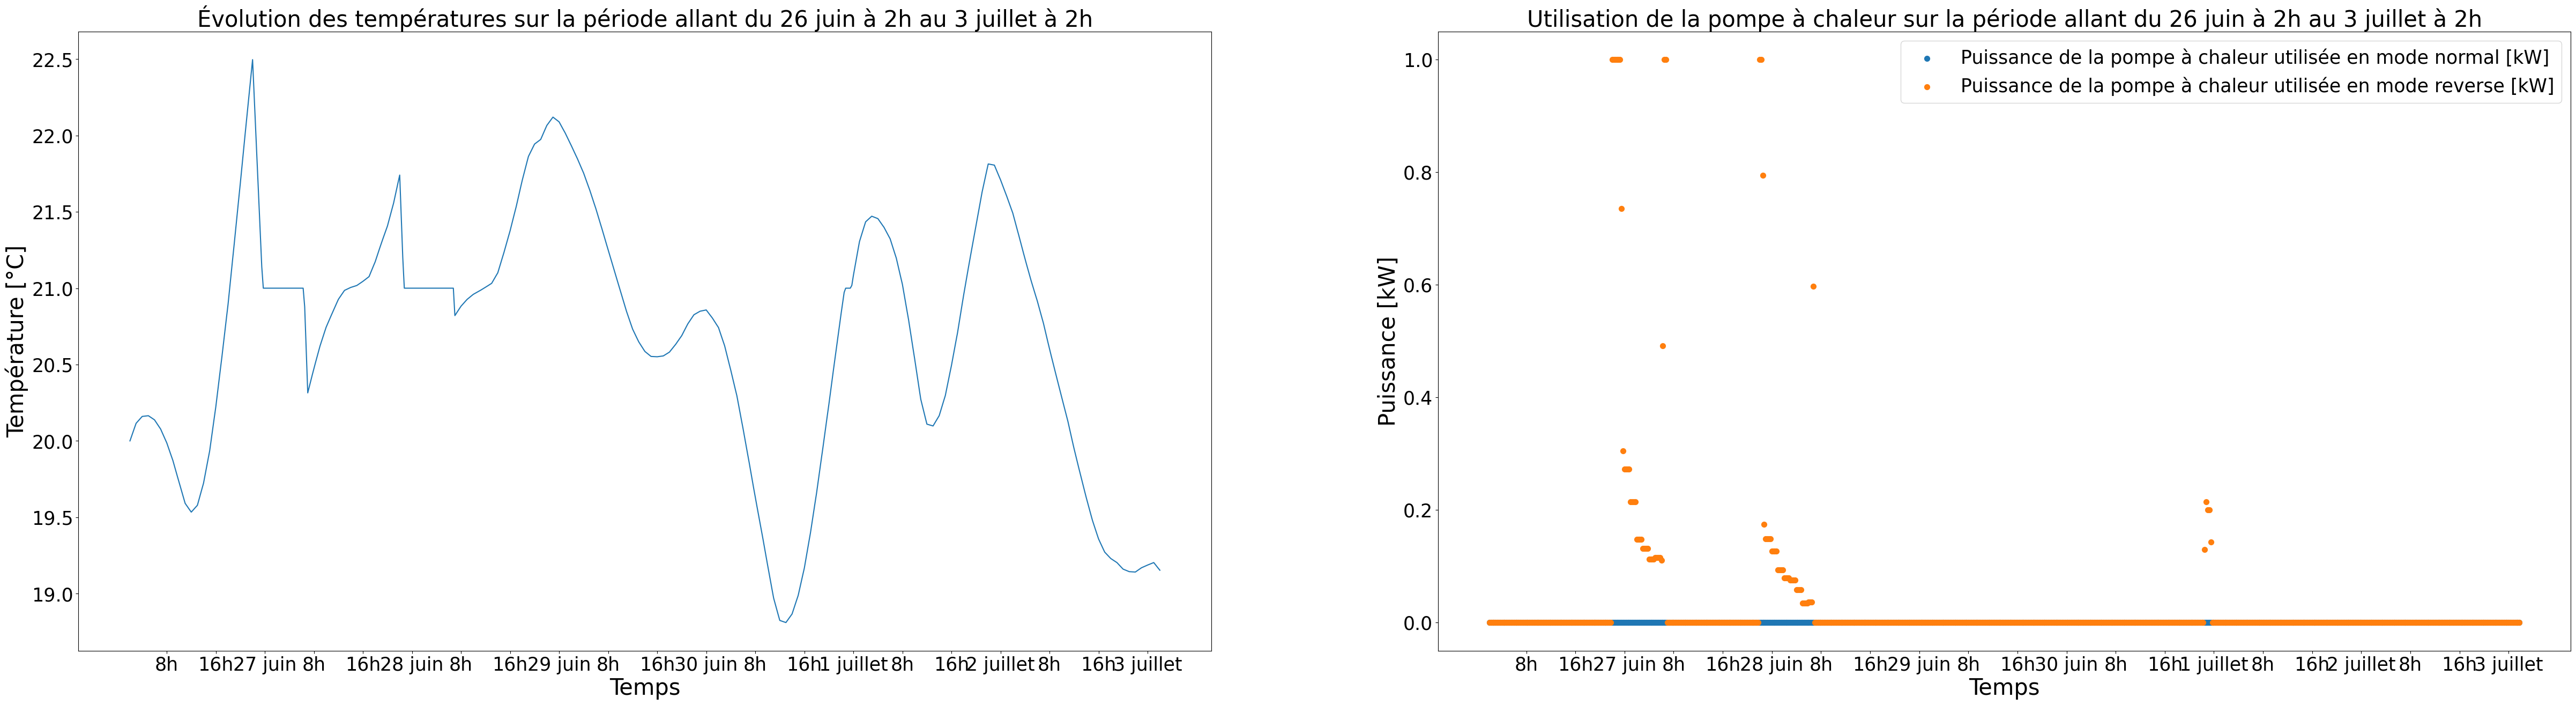

In [24]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Inconfort2:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

#### c) Commentaires

Pour la première (resp. seconde) période où les températures extérieures sont froides (resp. chaudes), on constate que la température intérieure a tendance à être dans la tranche inférieure (resp. supérieure) des températures admissibles voir en dessous (resp. au-dessus). De plus, l'inconfort pour la seconde période est plus faible car on préfère être au-dessus de la plage admissible qu'en dessous. De surcroît, le temps d'exécution de cette seconde tâche est plus élevé que pour la première car il y a plus de contraintes. Enfin, nous constatons à nouveau que la pompe à chaleur est plus utilisée à pleine puissance durant les heures creuses que pleines pour "consommer" le moins possible du budget.

On remplace à présent la notion d'inconfort décrite ci-dessus par une pénalisation quadratique : à présent l'inconfort  est proportionnel au *carré* du dépassement de la température maximale admissible, ou au *carré* du dépassement par le bas de la température minimale admissible (les coefficients de proportionnalité restent identiques).

<div class="alert alert-block alert-info"><b>Question 2.3</b> :<br> 
    Modélisez ce nouveau problème de façon linéaire, en utilisant une approximation. Cette approximation pourra par exemple être basée sur des tangentes  (choisissez un nombre pas trop élevé, par exemple 5). Expliquez votre technique de modélisation. Résolvez ce modèle approché, affichez les solutions et commentez (en particulier l'effet sur la solution par rapport au modèle d'inconfort initial).
</div>

Cette fois-ci, la fonction objectif est $\sum_{j=0}^{n} d_0.\delta_j^2 + d_1.\epsilon_j^2$ avec $\delta_j = max\{0,T_{inf}-T_j\}, j = 0,...,n$ et $\epsilon_j = max\{0,T_j-T_{sup}\}, j = 0,...,n$. L'ensemble des contraintes reste inchangé par rapport au modèle initial.

Soit un $j$ fixé. L'inconfort à l'instant $j$ peut être représenté par la fonction à une variable $f : \mathbb{R} \to \mathbb{R} : T_j \to d_0.max\{0,T_{inf}-T_j\}^2 + d_1.max\{0,T_j-T_{sup}\}^2$ représentée ci-dessous.

<img src="approximation_lineaire.png" width="800">

Considérons le membre de gauche de la somme. La fonction $g : \mathbb{R} \to \mathbb{R} : T \to max\{0, T_{inf}-T\}^2$ étant convexe et différentiable, nous pouvons la borner inférieurement avec les tangentes de la fonction prises à différents points $T_k, k = 1,...,l$. Nous pouvons dès lors approximer $d_0.\delta_j^2$ (avec $\delta_j := max\{0, T_{inf}-T\}$) par $d_0.\tilde{\delta_j}, j = 0,...,n$ avec $\tilde{\delta_j} = \max\limits_{k = 1,...,l}\{g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k)\}$. En linéarisant cette contrainte, nous obtenons les contraintes linéaires $\tilde{\delta_j} \geq g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k), k = 1,...,l$.

De la même manière, pour le membre de droite de la somme de la fonction objectif, nous obtenons que $d_1.\epsilon_j^2$ (avec $\epsilon_j := max\{0, T-T_{sup}\}$) par $d_1.\tilde{\epsilon_j}, j = 0,...,n$ avec $\tilde{\epsilon_j} \geq h(T_p) + \frac{dh(T)}{dT}_{\mid T = T_p}.(T-T_p), p = 1,...,q$ et $h : \mathbb{R} \to \mathbb{R} : T \to max\{0, T-T_{sup}\}^2$ qui est convexe et différentiable également.

Finalement, l'approximation linéaire du problème revient à

$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\tilde{\delta_j} + d_1.\tilde{\epsilon_j} \\
&T_0 = T_s\\
&\sum_{i=0}^{n-1} \frac{c_i}{4}.(x_i+y_i) \leq C\\
&\tilde{\delta_j} \geq g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k), k = 1,...,l , j = 0,...,n\\
&\tilde{\epsilon_j} \geq h(T_p) + \frac{dh(T)}{dT}_{\mid T = T_p}.(T-T_p), p = 1,...,q , j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

Il reste maintenant à déterminer les points $T_k$ et $T_p$. Pour les points $T_k$, nous constatons que la fonction $g$ est quadratique avant $T_{inf}$ et nulle après. La dérivée d'une fonction quadratique évoluant de façon linéaire, une bonne idée serait de prendre des points espacés à intervalle régulier jusqu'à atteindre $T_{inf}$, car la tangente à tous les points après $T_{inf}$ est la même que celle en $T_{inf}$. De la même manière, les $T_p$ seront pris à intervalles réguliers à partir de $T_{sup}$.

In [25]:
def min_new_inconfort_approx (start, length, C, distance, espace) :
    """
    Cette fonction calcule les moments auxquels nous devons allumer une pompe à chaleur dans un bâtiment de 360m³ à Montréal
    pour minimiser l'inconfort, avec une contrainte de budget.
    L'inconfort à un instant j est défini comme (less*max(0,T_inf-T_j)^2 + greater*max(0,T_j-T_sup)^2).
    Cette fonction ne pouvant pas être résolue avec un problème d'optimisation linéaire, nous calculons une approximation linéaire du problème.
    Nous considérons une période de `length` jours, commençant à l'instant `start`.

    Arguments
    ---------
    start     : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length    : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    C         : float qui indique le coût maximal qu'on est prêt à payer pour l'utilisation de la pompe à chaleur sur une période de `length` jours [$] ;
    distance  : int qui indique jusqu'à quelle distance (non incluse) des bornes de la zone des températures admissibles on désire des tangentes [-] ;
    espace    : float qui indique la longueur de l'intervalle entre deux abscisses pour lesquelles on calcule la tangente [°C].
    
    Retourne
    --------
    prob.status : string parmi {optimal, infeasible, unbounded} qui indique si la solution du problème est optimale,
                  si le problème est infaisable ou si la solution est non bornée ;
    prob.value  : float qui indique l'inconfort minimal [-]. Si le problème est impossible, prob.value = -inf.
                  Si le problème est non borné, prob.value = -inf ;
    T.value     : numpy array de float qui indique la température dans le bâtiment durant la période de sept jours considérée,
                  par intervalles de 15 minutes [°C] ;
    x.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    y.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    """    
    # Dans un premier temps, il faut trouver quels sont les coûts aux différents moments sur base de l'emplacement de l'instant de départ.
    c = np.repeat(plein, temps)
    debut = start%temps
    moments = np.concatenate((np.arange(debut,temps), np.arange(0,debut)))
    c[moments < start_plein*60/m] = creux
    c[moments >= end_plein*60/m] = creux
    c = np.tile(c,length)
    
    # Ensuite, il faut trouver les températures extérieures à ces moments et le COP de la pompe à chaleur utilisée en mode normal correspondant.
    Te = Text[start : start+length*temps]
    COPnor = COPnormal(Te)
    
    # Initialisation des variables du problème
    T = cp.Variable(temps*length + 1)
    x = cp.Variable(temps*length, nonneg=True)
    y = cp.Variable(temps*length, nonneg=True)
    ΔinfT = cp.Variable(temps*length+1, nonneg=True)
    ΔsupT = cp.Variable(temps*length+1, nonneg=True)
    
    # Modélisation du problème
    objective = cp.Minimize(cp.sum(less*ΔinfT + greater*ΔsupT))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c,(x+y))*m/60) <= C,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= puiMax]
    for k in np.arange(espace, distance, espace) :
        constraints.append(ΔinfT >= k**2 - 2*k*(T-(Tinf-k))) # Par rapport à la formule du problème, on prend Tk = Tinf - k
    for p in np.arange(espace, distance, espace) :
        constraints.append(ΔsupT >= p**2 + 2*p*(T-(Tsup+p))) # Par rapport à la formule du problème, on prend Tp = Tsup + p

    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start = True)

    return (prob.status, prob.value, T.value, x.value, y.value)

#### a) Intervalle de temps allant du 15 mai à 22h30 au 22 mai à 22h30

In [26]:
start = 13050
length = 7
Cout1 = min_cout(start, length)[1]
t0 = time.time()
(result1, Inconfort1,T1,x1,y1) = min_new_inconfort_approx(start, length, Cout1/2, 3, 1)
t1 = time.time()

Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : 10980.726. L'exécution a duré 372.651ms.


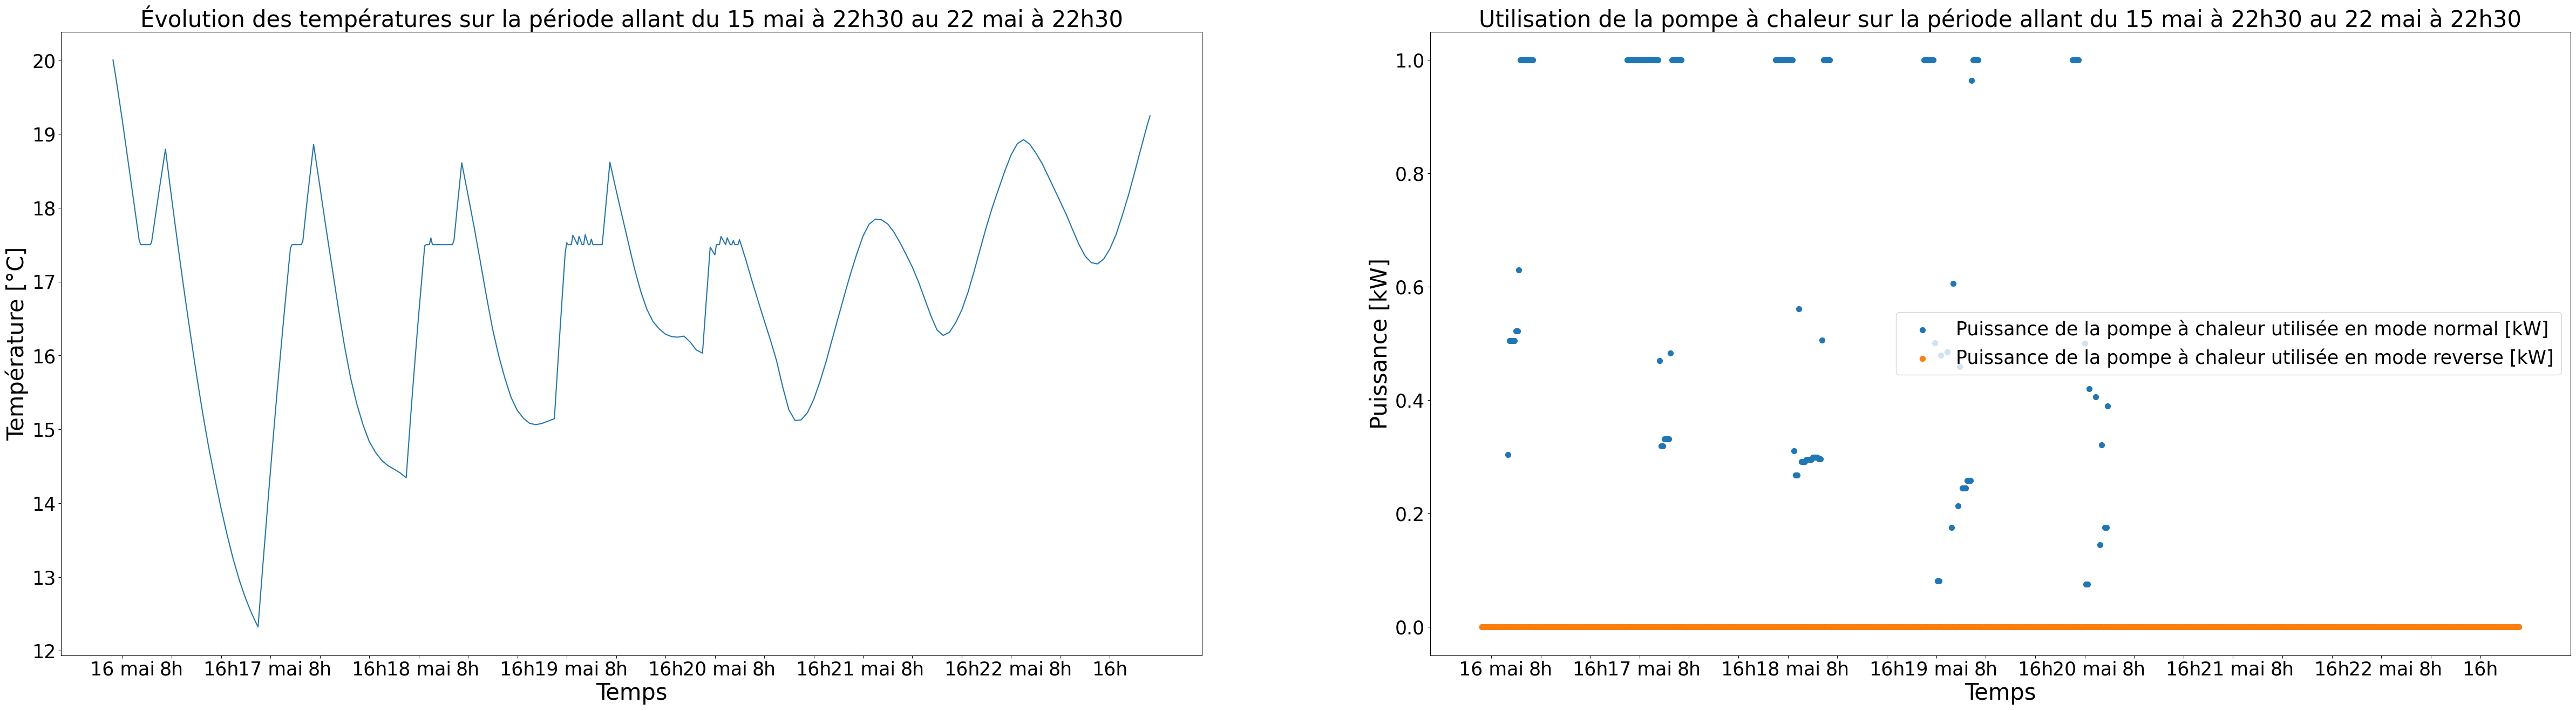

In [27]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : {Inconfort1:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

#### b) Intervalle de temps allant du 26 juin à 2h au 3 juillet à 2h

In [28]:
start = 17000
length = 7
Cout2 = min_cout(start, length)[1]
t0 = time.time()
(result2, Inconfort2,T2,x2,y2) = min_new_inconfort_approx(start, length, Cout2/2, 1, 0.33)
t1 = time.time()

Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 69.534. L'exécution a duré 253.664ms.


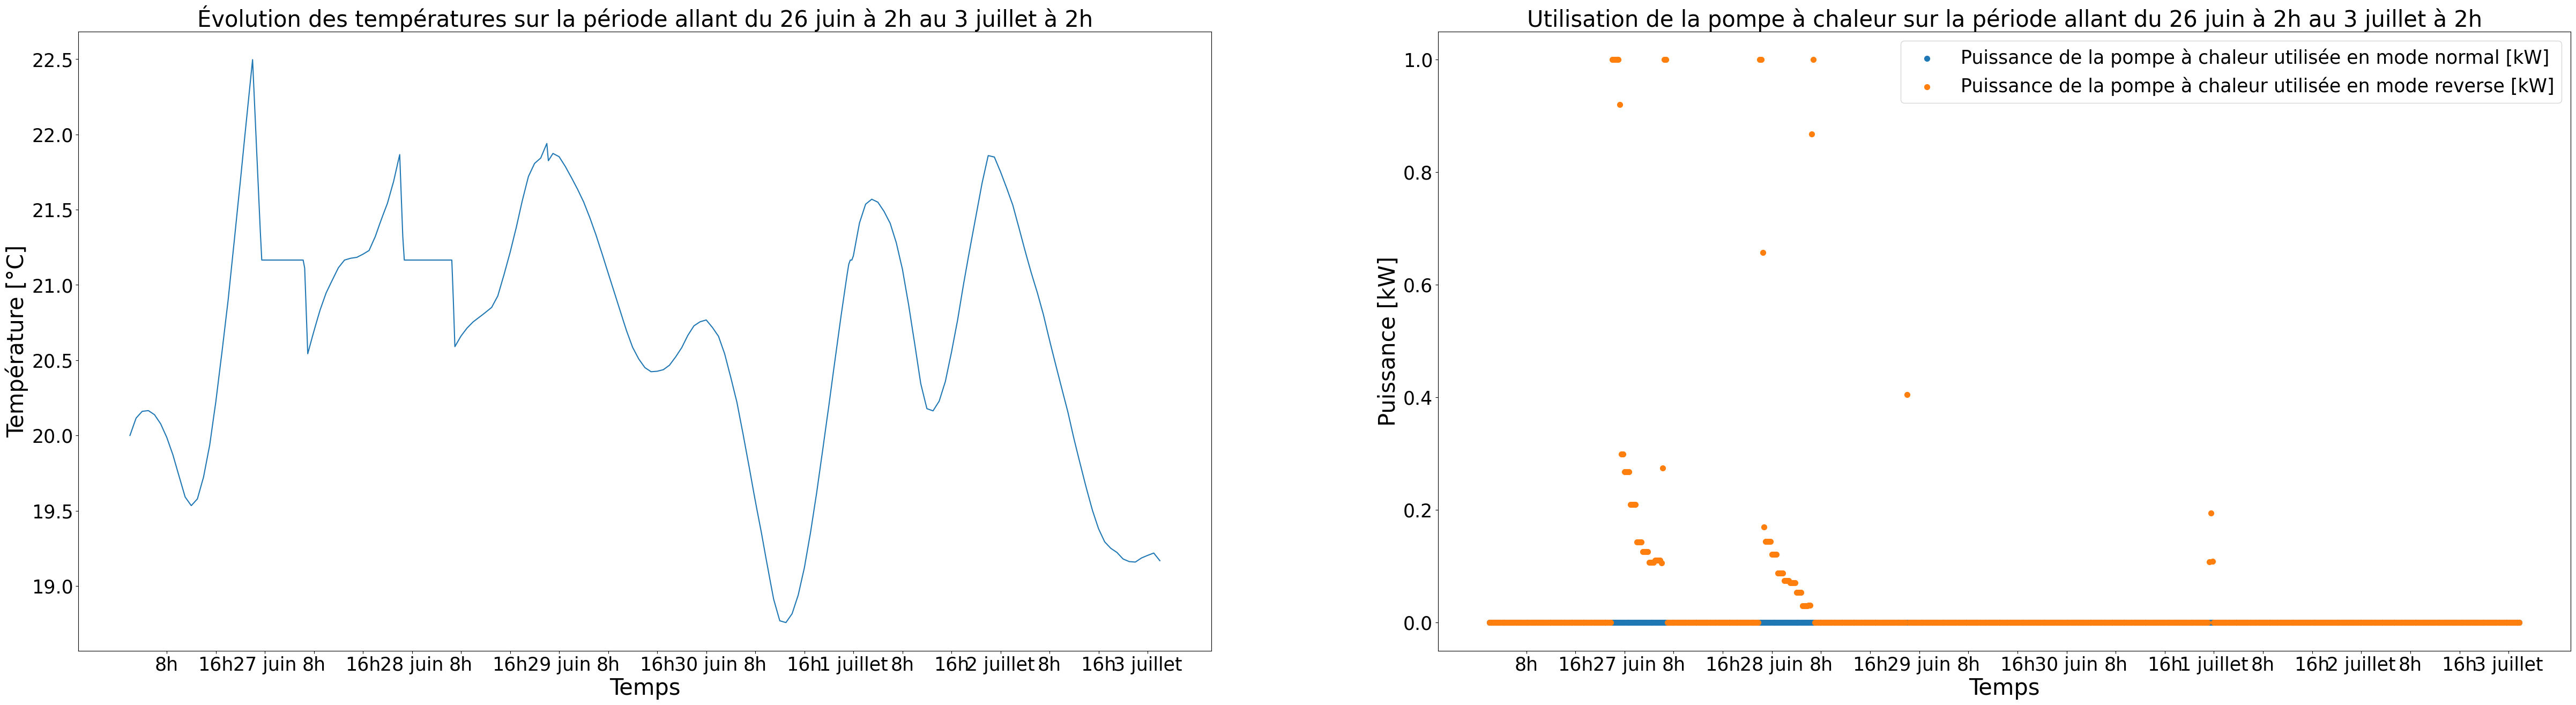

In [29]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Inconfort2:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

#### c) Commentaires

Aussi bien pour la première que pour la seconde période, nous constatons que les graphes ont une allure similaire à ceux obtenus avec le modèle initial. Nous constatons toutefois que les graphes de température de l'approximation linéaire de ce nouveau modèle ont tendances à être légèrement moins lisse avec un peu plus de faibles oscillations par endroits. Concernant le temps d'exécution, la résolution de ce nouveau modèle prend de manière générale plus de temps que le modèle initial. Le temps d'exécution augmente avec le nombre de tangentes.

Il nous reste à analyser l'inconfort minimal. Celui-ci a un comportement particulier. En effet, pour la première période, il est beaucoup plus élevé que celui du modèle initial alors que pour la seconde période, l'inconfort minimal à diminuer par rapport au modèle initial. Ce phénomène est tout à fait logique. En effet, pour la seconde période, la température se trouve la majeure partie du temps à une distance inférieure à 1 des bornes de températures désirées. Lorsque nous mettons cette distance au carré, le nombre obtenu est plus petit que la distance (lorsque la distance est inférieure à 1). Dès lors, l'inconfort est moindre : $ax^2 \leq ax \text{ si } x \leq 1$. Pour la première période, la température s'éloigne beaucoup plus de la zone des températures désirées et la mise au carré fait donc fortement augmenter l'inconfort.

<div class="alert alert-block alert-info"><b>Question 2.4</b> :<br> 
    Pour terminez cette partie, résolvez encore une fois ce nouveau modèle, mais cette fois de façon exacte, en utilisant un solveur quadratique. Comparez avec la solution approchée obtenue précédemment (solutions, temps de calcul).
</div>

In [30]:
def min_new_inconfort (start, length, C) :
    """
    Cette fonction calcule les moments auxquels nous devons allumer une pompe à chaleur dans un bâtiment de 360m³ à Montréal
    pour minimiser l'inconfort, avec une contrainte de budget.
    L'inconfort à un instant j est défini comme (less*max(0,T_inf-T_j)^2 + greater*max(0,T_j-T_sup)^2).
    Le problème est résolu de manière exacte.
    Nous considérons une période de `length` jours, commençant à l'instant `start`.
    
    Préalable
    ---------
    Avoir installé le module de résolution clarabel (pip install clarabel)

    Arguments
    ---------
    start  : int qui indique le numéro de l'instant qui débute la période de `length` jours [-] ;
    length : int qui indique le nombre de jours sur lequel l'algorithme d'optimisation doit être appliqué [jour] ;
    C      : float qui indique le coût maximal qu'on est prêt à payer pour l'utilisation de la pompe à chaleur sur une période de `length` jours [$] ;
    
    Retourne
    --------
    prob.status : string parmi {optimal, infeasible, unbounded} qui indique si la solution du problème est optimale,
                  si le problème est infaisable ou si la solution est non bornée ;
    prob.value  : float qui indique l'inconfort minimal [-]. Si le problème est impossible, prob.value = -inf.
                  Si le problème est non borné, prob.value = -inf ;
    T.value     : numpy array de float qui indique la température dans le bâtiment durant la période de sept jours considérée,
                  par intervalles de 15 minutes [°C] ;
    x.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode normal, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    y.value     : numpy array de float qui indique la puissance de la pompe à chaleur, utilisée en mode reverse, durant les différents
                  intervalles de temps de 15 minutes [kW] ;
    """    
    # Dans un premier temps, il faut trouver quels sont les coûts aux différents moments sur base de l'emplacement de l'instant de départ.
    c = np.repeat(plein, temps)
    debut = start%temps
    moments = np.concatenate((np.arange(debut,temps), np.arange(0,debut)))
    c[moments < start_plein*60/m] = creux
    c[moments >= end_plein*60/m] = creux
    c = np.tile(c,length)
    
    # Ensuite, il faut trouver les températures extérieures à ces moments et le COP de la pompe à chaleur utilisée en mode normal correspondant.
    Te = Text[start : start+length*temps]
    COPnor = COPnormal(Te)
    
    # Initialisation des variables du problème
    T = cp.Variable(temps*length + 1)
    x = cp.Variable(temps*length, nonneg=True)
    y = cp.Variable(temps*length, nonneg=True)
    ΔinfT = cp.Variable(temps*length+1, nonneg=True)
    ΔsupT = cp.Variable(temps*length+1, nonneg=True)
    
    # Modélisation du problème
    objective = cp.Minimize(cp.sum(less*cp.square(ΔinfT) + greater*cp.square(ΔsupT)))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c,(x+y))*m/60) <= C,
                   ΔinfT >= Tinf - T,
                   ΔsupT >= T - Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= puiMax]

    # Résolution du problème
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL, warm_start = True)

    return (prob.status, prob.value, T.value, x.value, y.value)

#### a) Intervalle de temps allant du 15 mai à 22h30 au 22 mai à 22h30

In [31]:
start = 13050
length = 7
Cout1 = min_cout(start, length)[1]
t0 = time.time()
(result1, Inconfort1,T1,x1,y1) = min_new_inconfort(start, length, Cout1/2)
t1 = time.time()

Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : 13905.627. L'exécution a duré 140.866ms.


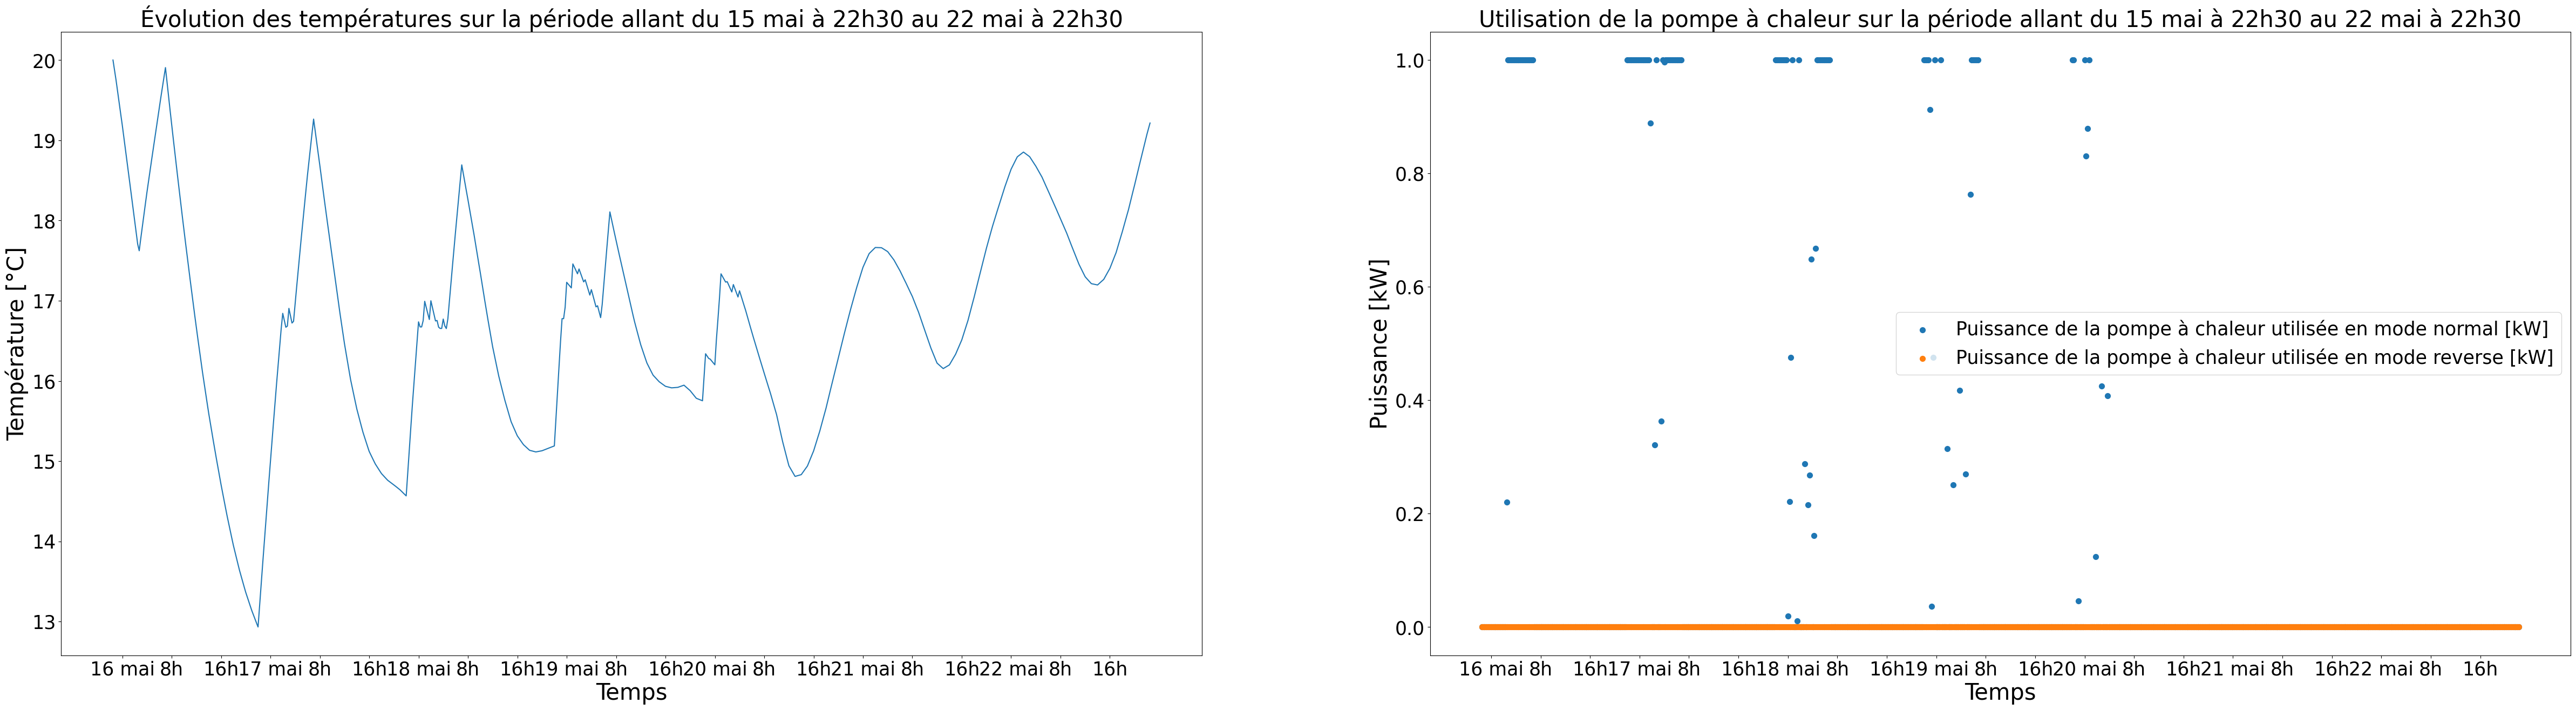

In [32]:
if (result1 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result1 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 15 mai à 22h30 au 22 mai à 22h30 : {Inconfort1:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T1, x1, y1, ["15 mai à 22h30", "22 mai à 22h30"], np.arange(13050+6,13050+672,32),["16 mai", "8h", "16h", "17 mai", "8h", "16h", "18 mai", "8h", "16h", "19 mai", "8h", "16h", "20 mai", "8h", "16h", "21 mai", "8h", "16h", "22 mai", "8h", "16h"])

#### b) Intervalle de temps allant du 26 juin à 2h au 3 juillet à 2h

In [33]:
start = 17000
length = 7
Cout2 = min_cout(start, length)[1]
t0 = time.time()
(result2, Inconfort2,T2,x2,y2) = min_new_inconfort(start, length, Cout2/2)
t1 = time.time()

Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 74.705. L'exécution a duré 116.031ms.


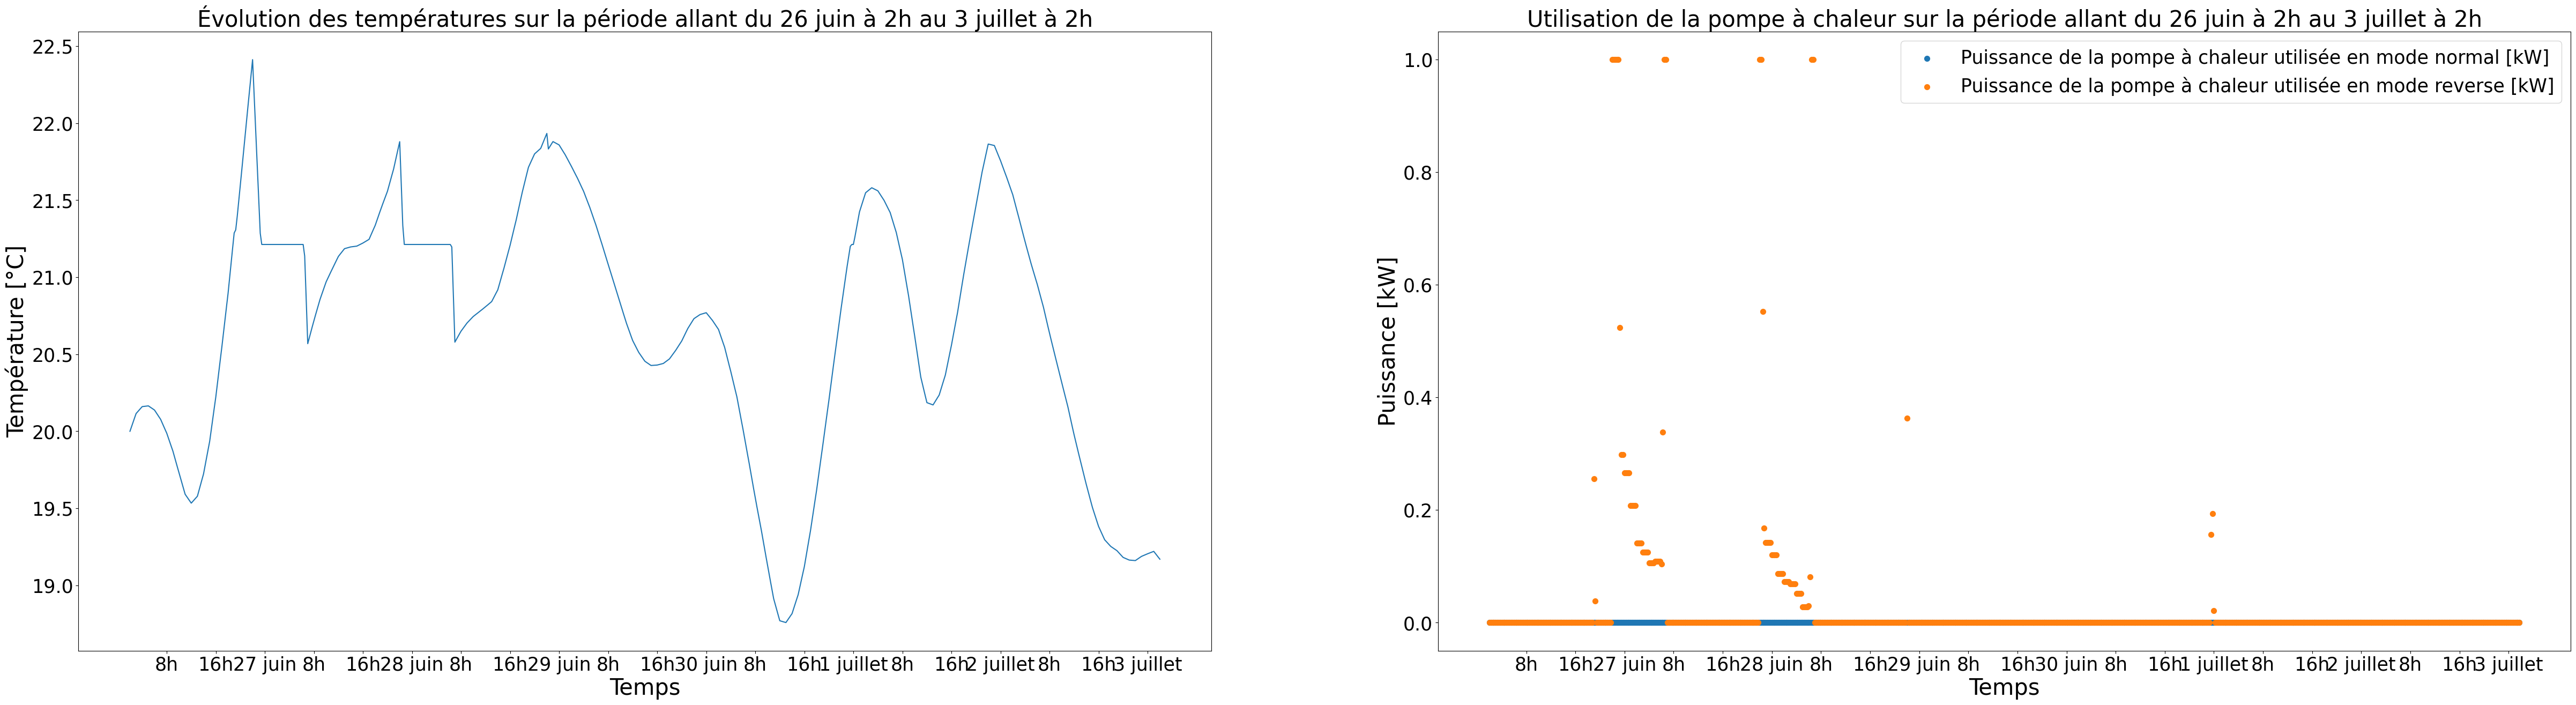

In [34]:
if (result2 == "infeasible") :
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded") :
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else :
    print(f"Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Inconfort2:.3f}. L'exécution a duré {((t1-t0)*1000):.3f}ms.")
    graphe(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000+24,17000+672,32),["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])

#### c) Commentaires

Nous constatons que la solution exacte est plus élevée que celle approchée précédemment. En effet, la solution exacte peut être vue comme la limite lorsque le nombre de tangentes tant vers l'infini de l'approximation. Les tangentes étant toujours en-dessous du graphe, la valeur de la fonction objectif sera moindre dans le cas de l'approximation.
Nous pouvons donc nous rapprocher de cette solution optimale en augmentant d'une part la distance entre la zone des températures admissibles et l'abscisse à laquelle la dernière tangente est calculée, d'autre part en diminuant l'écart entre les abscisses auxquelles les tangentes sont calculées. Cependant, plus nous désirons améliorer la précision de l'approximation linéaire, plus l'exécution prendra du temps, alors que la résolution exacte se fera de manière beaucoup plus rapide.

**Tâche 3** : on voudrait à présent mieux comprendre le compromis qui existe entre le budget alloué et l'inconfort total qui en résulte. Proposez un **graphique représentant au mieux cette relation entre budget et inconfort**, où on fera varier le budget entre entre zéro et le coût minimal identifié lors de la tâche 1 (ce budget sera indiqué en pourcentage, de 0 à 100%). Ceci nécessitera la résolution de plusieurs problèmes, et il sera judicieux d'utiliser la fonctionnalité _warm start_ du solver pour accélérer les calculs.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- graphique demandé + temps de calcul (total et moyenne par problème) + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées  lors des tâches 1 et 2
</div>

---

<div class="alert alert-block alert-info"><b>Question 3.1</b> :<br> 
    Fournissez le graphique et les commentaires demandé ci-dessus
</div>

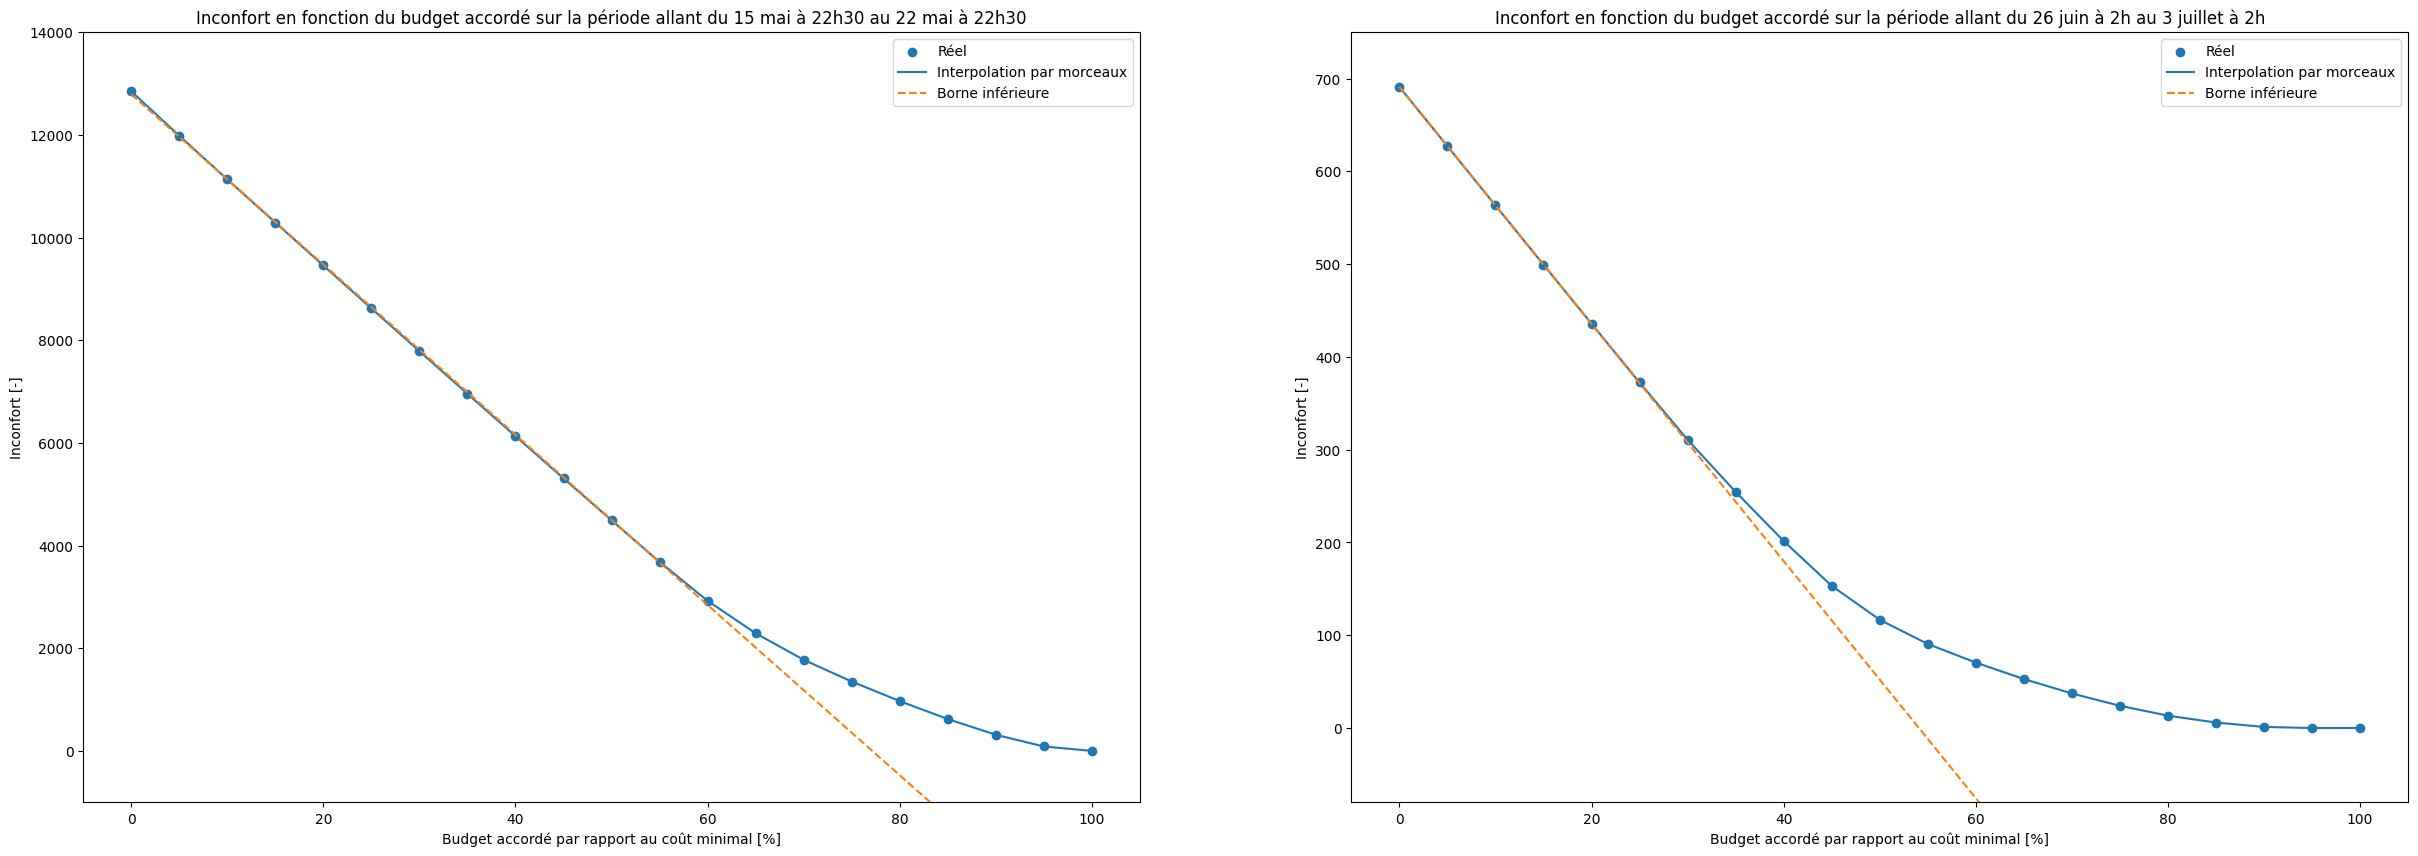

Temps d'exécution pour la période allant du 15 mai à 22h30 au 22 mai à 22h30 : 4.189s
Temps d'exécution moyen pour la période allant du 15 mai à 22h30 au 22 mai à 22h30 : 0.199s
Temps d'exécution pour la période allant du 26 juin à 2h au 3 juillet à 2h : 3.322s
Temps d'exécution moyen pour la période allant du 26 juin à 2h au 3 juillet à 2h : 0.158s


In [35]:
t10 = time.time()

budget = cp.Parameter(nonneg=True)

start1 = 13050
length1 = 7
Cout1 = min_cout(start1, length1)[1]
budget1 = np.linspace(0,Cout1,21)
inconfort1 = np.zeros(21)

for i in range (21) :
    budget.value = budget1[i]
    inconfort1[i] = min_inconfort(start1, length1, budget)[1]
    
t11 = time.time()

t20 = time.time()

start2 = 17000
length2 = 7
Cout2 = min_cout(start2, length2)[1]
budget2 = np.linspace(0,Cout2,21)
inconfort2 = np.zeros(21)

for i in range (21) :
    budget.value = budget2[i]
    inconfort2[i] = min_inconfort(start2, length2, budget)[1]
    
t21 = time.time()

fig = plt.figure(figsize=(30,10))
fig.tight_layout(pad=2.0)
plt.subplot(1,2,1)
plt.scatter(np.arange(0,101,5),inconfort1, label = "Réel")
plt.plot(np.arange(0,101,5),inconfort1, label = "Interpolation par morceaux")
# Approximation linéaire :
coeff = np.polyfit(budget1[:13], inconfort1[:13], 1)
val = np.polyval(coeff, Cout1*np.arange(0,101,5)/100)
plt.plot(np.arange(0,101,5), val, "--", label = "Borne inférieure")
plt.title("Inconfort en fonction du budget accordé sur la période allant du 15 mai à 22h30 au 22 mai à 22h30")
plt.xlabel("Budget accordé par rapport au coût minimal [%]")
plt.ylabel("Inconfort [-]")
plt.ylim((-1000,14000))
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.scatter(np.arange(0,101,5),inconfort2, label = "Réel")
plt.plot(np.arange(0,101,5),inconfort2, label = "Interpolation par morceaux")
# Borne inférieure :
coeff2 = np.polyfit(budget2[:3], inconfort2[:3], 1)
val2 = np.polyval(coeff2, Cout2*np.arange(0,101,5)/100)
plt.plot(np.arange(0,101,5), val2, "--", label = "Borne inférieure")
plt.title("Inconfort en fonction du budget accordé sur la période allant du 26 juin à 2h au 3 juillet à 2h")
plt.xlabel("Budget accordé par rapport au coût minimal [%]")
plt.ylabel("Inconfort [-]")
plt.ylim((-80,750))
plt.legend(loc = 'upper right')

plt.show()

print(f"Temps d'exécution pour la période allant du 15 mai à 22h30 au 22 mai à 22h30 : {t11-t10:.3f}s")
print(f"Temps d'exécution moyen pour la période allant du 15 mai à 22h30 au 22 mai à 22h30 : {(t11-t10)/21:.3f}s")
print(f"Temps d'exécution pour la période allant du 26 juin à 2h au 3 juillet à 2h : {t21-t20:.3f}s")
print(f"Temps d'exécution moyen pour la période allant du 26 juin à 2h au 3 juillet à 2h : {(t21-t20)/21:.3f}s")

L'inconfort diminue lorsque le budget augmente, jusqu'à atteindre le coût optimal du problème de la tâche 1. Pour ce coût optimal, il est possible de rester parfaitement dans la zone des températures admissibles et l'inconfort est donc nul. Il est évident que cette solution d'inconfort nulle reste valable pour un budget supérieur au coût optimal, et que l'inconfort sera nulle pour tout budget supérieur au coût optimal de la tâche 1.

<div class="alert alert-block alert-info"><b>Question 3.2</b> :<br> 
    Expliquez la pente linéaire observée dans le graphique obtenu. Recalculez la valeur de la pente à partir des informations fournies par le solver pour la résolution avec le budget maximal (tâche 2), et comparez à celle du graphique. Enfin, expliquez pourquoi le graphique cesse à un moment d'être une droite.
</div>

La théorie prédit qu'une modification linéaire du membre de droite d'une contraite conduit à une diminution linéaire (car c'est une minimisation) du coût optimal jusqu'au point où la base n'est plus admissible. Dans ce cas-ci, la diminution n'est pas tout à fait linéaire car la base change. Cependant, jusqu'à environ $60\%$ (resp. $40\%$) du budget minimal, le changement de base ne se marque pas très fort. Nous pouvons donc utiliser la théorie pour donner une pente linéaire qui approxime la variation de l'inconfort en fonction du budget.

L'inconfort diminuera donc approximativement de $\Delta B . \upsilon_C^*$, avec $\Delta B$ la variation de budget et $\upsilon_C^*$ la valeur de la variable du duale relative à la contrainte du budget avant la modification du budget, jusqu'à ce que le changement de base devienne important. La pente de l'inconfort en fonction du budget est donc environ égale à $\upsilon_C^*$, qui vaut en moyenne $-2035$ pour la première période et $-677$ pour la seconde période (les mesures ont été prises jusqu'à respectivement $55\%$ et $30\%$ du coût optimal).

In [36]:
print(f"Valeur de la pente de la droite dans le graphique de l'inconfort en fonction du budget pour la période 1 : {((inconfort1[11] - inconfort1[0])/(budget1[11] - budget1[0])):.3f}")
print(f"Valeur de la pente de la droite dans le graphique de l'inconfort en fonction du budget pour la période 2 : {((inconfort2[6] - inconfort2[0])/(budget2[6] - budget2[0])):.3f}")

Valeur de la pente de la droite dans le graphique de l'inconfort en fonction du budget pour la période 1 : -2037.343
Valeur de la pente de la droite dans le graphique de l'inconfort en fonction du budget pour la période 2 : -682.039


Les pentes des droites prises sur les graphiques correspondent aux pentes calculées avec la théorie (avec une petite marge d'erreur du au fait que la diminution du budget n'est pas parfaitement linéaire).

Le graphique cesse de suivre une droite à un moment car la base optimale change fortement. La solution optimale décroit alors plus lentement jusqu'à atteindre un inconfort nul. La droite reste cependant une borne inférieure sur le coût optimal.

---

<div class="alert alert-block alert-info"><b>Bonus</b><br>
    Estimez l'effet de l'utilisation d'une version imprécise des données de température (prévisions)<br>
</div>
Ce bonus est optionnel, et ne conduit pas à l'obtention de points supplémentaires : il est seulement destiné à attirer votre
    attention sur le caractère artificiel de la situation proposée, où on connaît parfaitement et à l'avance les températures extérieures.

## Consignes et conseils
- Le projet se réalise par groupe de (maximum) quatre étudiants (cf. groupes constitués sur Moodle). 

- L'assistant responsable du projet est Guillaume Van Dessel. Toutes les  questions sur le projet doivent être posées via Moodle dans le forum prévu pour le projet (et pas par message/mail individuel). Des permanences seront prévues, et seront annoncées via Moodle.

- Il est fortement suggéré d'utiliser un langage de modélisation pour formuler et résoudre vos problèmes d'optimisation linéaire. Nous conseillons d'utiliser le module CVXPY combiné au solver d'optimisation HIGHS (nous avons vérifié que cette combinaison est suffisamment performance pour le projet).

- Les groupes peuvent échanger leurs réflexions, partager leurs idées et comparer leurs résultats. Ils ne peuvent pas recopier les raisonnements, les solutions ou les codes informatiques. L'utilisation de toute information ou aide extérieure doit obligatoirement être mentionnée dans le rapport, en citant la source.

- Votre rapport final sera constitué de ce notebook complété, où vous aurez inséré vos codes, vos résultats, vos graphiques et commentaires.

- Ce rapport  est à remettre au plus tard le **mercredi 24 mai 2023** à minuit (soir), via Moodle, sous la forme d'une archive compressée contenant votre notebook et tous les fichiers nécessaires pour le faire fonctionner (code Python, etc.). Le notebook doit contenir les cellules sous forme déjà évaluée (résultats, tableaux, graphiques, etc.), mais doit pouvoir également être ré-évalué en entier. 

- Organisez efficacement votre travail de groupe, et répartissez vous le travail. Les tâches à effectuer durant cette seconde partie sont *largement indépendantes* les unes des autres.


### Changelog
- 2023-03-24 v1
- 2023-04-23 v1.1 avec récapitulatif des précisions apportées sur Moodle (en bleu)
- 2023-04-28 description des tâches de la seconde partie
- 2023-05-12 v2 avec le format attendu (notebook) pour le rapport final